**Analysis by regions: Northern, Central and Southern Strait of Georgia**

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
import glob
# For polygons
from shapely.geometry import Polygon, Point

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Check transect on GridX and GridY map to get latitudes and longitudes for Ocean Parcels coordinates

In [2]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])
bathy = xr.open_dataset(path['bat'])

- Northern Strait: 2 sub regions
- Central Strait
- Southern Strait: 2 subregions
- Haro Strait
- Juan de Fuca

In [3]:
# Northern Strait
# Subregion Left
Nx1_1, Ny1_1 = [115,185], [665,650]
Nx1_2, Ny1_2 = [110,220], [510,565]
#Subregion Right
Nx2_1, Ny2_1 = [228,258], [650,565]
Nx2_2, Ny2_2 = [220,258], [565,565]
Nx2_3, Ny2_3 = [185,228], [650,650]
###################################
# Central Strait
Cx1_1, Cy1_1 = [185,300], [505,505]
Cx1_2, Cy1_2 = [185,170], [505,540]
Cx1_3, Cy1_3 = [170,220], [540,565]
Cx1_4, Cy1_4 = [220,258], [565,565]
Cx1_5, Cy1_5 = [258,300], [565,505]
###################################
# Southern Strait
# Subregion North
Sx1_1, Sy1_1 = [202,292], [505,505]
Sx1_2, Sy1_2 = [300,320], [503,457]
Sx1_3, Sy1_3 = [210,238], [500,465]
Sx1_4, Sy1_4 = [238,245], [465,410]
Sx1_5, Sy1_5 = [320,302], [457,410]
Sx1_6, Sy1_6 = [245,302], [410,410]
# Subregion South
Sx2_1, Sy2_1 = [245,302], [410,410]
Sx2_2, Sy2_2 = [245,280], [410,350]
Sx2_3, Sy2_3 = [280,342], [350,315]
Sx2_4, Sy2_4 = [302,370], [410,390]
###################################
# JdF
Jx1_1, Jy1_1 = [145,145], [230,320]
Jx1_2, Jy1_2 = [145,80], [320,410]
Jx1_3, Jy1_3 = [145,60], [230,280]

# Puget Sound
Px1, Py1 = [203,312], [230,230]
# Haro Strait
Hx1_1, Hy1_1 = [200, 250],[305,300]
Hx1_2, Hy1_2 = [225, 242],[355,355]
Hx1_3, Hy1_3 = [244, 247],[355,320]

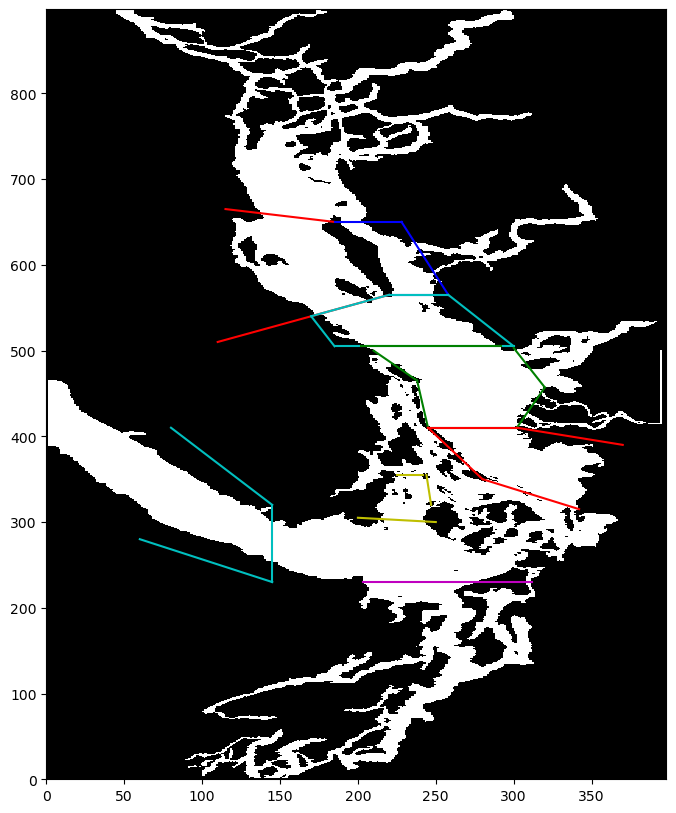

In [4]:
fig, ax = plt.subplots(figsize = (8,10))
ax.pcolormesh(mask['tmask'][0][0], cmap = 'grey')
ax.plot(Nx1_1, Ny1_1, 'r')
ax.plot(Nx1_2, Ny1_2, 'r')
#
ax.plot(Nx2_1, Ny2_1, 'b')
ax.plot(Nx2_2, Ny2_2, 'b')
ax.plot(Nx2_3, Ny2_3, 'b')
##########################
ax.plot(Cx1_1, Cy1_1, 'c')
ax.plot(Cx1_2, Cy1_2, 'c')
ax.plot(Cx1_3, Cy1_3, 'c')
ax.plot(Cx1_4, Cy1_4, 'c')
ax.plot(Cx1_5, Cy1_5, 'c')
##########################
ax.plot(Sx1_1, Sy1_1, 'g')
ax.plot(Sx1_2, Sy1_2, 'g')
ax.plot(Sx1_3, Sy1_3, 'g')
ax.plot(Sx1_4, Sy1_4, 'g')
ax.plot(Sx1_5, Sy1_5, 'g')
ax.plot(Sx1_6, Sy1_6, 'g')
##########################
ax.plot(Sx2_1, Sy2_1, 'r')
ax.plot(Sx2_2, Sy2_2, 'r')
ax.plot(Sx2_3, Sy2_3, 'r')
ax.plot(Sx2_4, Sy2_4, 'r')
##########################
ax.plot(Jx1_1, Jy1_1, 'c')
ax.plot(Jx1_2, Jy1_2, 'c')
ax.plot(Jx1_3, Jy1_3, 'c')
##########################
ax.plot(Px1, Py1, 'm')
##########################
ax.plot(Hx1_1, Hy1_1, 'y')
ax.plot(Hx1_2, Hy1_2, 'y')
ax.plot(Hx1_3, Hy1_3, 'y')

Check the ones in the Northern Strait, Central Strait, Southern Strait, Haro Strait and Juan de Fuca Strait

**Get Polygons and the Area where there's water**

**Northern Strait and Subregions**

Subregion Left

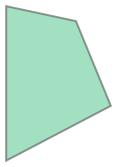

In [5]:
polygon_coords_N1 = [
    (Nx1_1[0], Ny1_1[0]),
    (Nx1_1[1], Ny1_1[1]),
    (Nx1_2[1], Ny1_2[1]),
    (Nx1_1[0], Ny1_2[0]),
    (Nx1_1[0], Ny1_1[0])
]
polygon_N1 = Polygon(polygon_coords_N1)
polygon_N1

Subregion Right

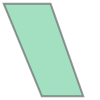

In [6]:
polygon_coords_N2 = [
    (Nx2_3[0], Ny2_3[0]),
    (Nx2_1[0], Ny2_1[0]),
    (Nx2_2[1], Ny2_2[1]),
    (Nx2_2[0], Ny2_2[0])
]
polygon_N2 = Polygon(polygon_coords_N2)
polygon_N2

**Central Strait**

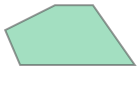

In [7]:
polygon_coords_C1 = [
    (Cx1_1[1], Cy1_1[1]),
    (Cx1_1[0], Cy1_1[0]),
    (Cx1_2[0], Cy1_2[0]),
    (Cx1_2[1], Cy1_2[1]),
    (Cx1_3[1], Cy1_3[1]),
    (Cx1_4[1], Cy1_4[1])
]
polygon_C1 = Polygon(polygon_coords_C1)
polygon_C1

**Southern Strait and Subregions**

Subregion North

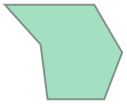

In [8]:
polygon_coords_S1 = [
    (Sx1_1[0], Sy1_1[0]),
    (Sx1_1[1], Sy1_1[1]),
    (Sx1_2[1], Sy1_2[1]),
    (Sx1_5[1], Sy1_5[1]),
    (Sx1_6[0], Sy1_6[0]),
    (Sx1_4[0], Sy1_4[0])
]
polygon_S1 = Polygon(polygon_coords_S1)
polygon_S1

Subregion South

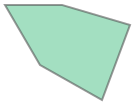

In [9]:
polygon_coords_S2 = [
    (Sx2_1[1], Sy2_1[1]),
    (Sx2_1[0], Sy2_1[0]),
    (Sx2_2[1], Sy2_2[1]),
    (Sx2_3[1], Sy2_3[1]),
    (Sx2_4[1], Sy2_4[1])
]
polygon_S2 = Polygon(polygon_coords_S2)
polygon_S2

**Haro Strait**

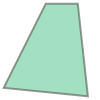

In [10]:
polygon_coords_H1 = [
    (Hx1_1[1], Hy1_1[1]),
    (Hx1_1[0], Hy1_1[0]),
    (Hx1_2[0], Hy1_2[0]),
    (Hx1_3[0], Hy1_3[0])

]
polygon_H1 = Polygon(polygon_coords_H1)
polygon_H1

**Juan de Fuca Strait**

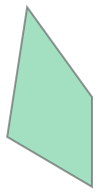

In [11]:
polygon_coords_J1 = [
    (Jx1_1[0], Jy1_1[0]),
    (Jx1_1[1], Jy1_1[1]),
    (Jx1_2[1], Jy1_2[1]),
    (Jx1_3[1], Jy1_3[1])

]
polygon_J1 = Polygon(polygon_coords_J1)
polygon_J1

**Now, get the grid point where there's water inside the polygons**

In [12]:
def inside_polygon_grid_and_area(polygon, depth):
    #
    mask = xr.open_dataset(path['mask'])
    #
    tmask = mask['tmask'][0, depth].values
    e1t = mask['e1t'][0].values
    e2t = mask['e2t'][0].values
    e3t = mask['e3t_0'][0, depth].values
    x_coords, y_coords = np.meshgrid(np.arange(tmask.shape[1]), np.arange(tmask.shape[0]))
    #
    # Flatten arrays
    x_flat = x_coords.ravel()
    y_flat = y_coords.ravel()
    tmask_flat = tmask.ravel()
    e1t_flat = e1t.ravel()
    e2t_flat = e2t.ravel()
    e3t_flat = e3t.ravel()
    #
    #
    points = np.array([Point(x, y) for x, y in zip(x_flat, y_flat)])
    inside_mask = np.array([polygon.contains(point) for point in points]) & (tmask_flat == 1)
    #
    #
    x_inside = x_flat[inside_mask]
    y_inside = y_flat[inside_mask]
    areas = e1t_flat[inside_mask] * e2t_flat[inside_mask]
    volumes = e1t_flat[inside_mask] * e2t_flat[inside_mask] * e3t_flat[inside_mask]

    #
    # Total area in square meters
    AREA = np.sum(areas) / 1e6 # to Km
    VOLUME = np.sum(volumes) / 1e9
    #
    return x_inside.tolist(), y_inside.tolist(), AREA, VOLUME

In [13]:
depth = 0
points_x_N1,points_y_N1, area_N1, volume_N1 = inside_polygon_grid_and_area(polygon_N1, depth=depth)
points_x_N2,points_y_N2, area_N2, volume_N2 = inside_polygon_grid_and_area(polygon_N2, depth=depth)
points_x_C1,points_y_C1, area_C1, volume_C1 = inside_polygon_grid_and_area(polygon_C1, depth=depth)
points_x_S1,points_y_S1, area_S1, volume_S1 = inside_polygon_grid_and_area(polygon_S1, depth=depth)
points_x_S2,points_y_S2, area_S2, volume_S2 = inside_polygon_grid_and_area(polygon_S2, depth=depth)
points_x_H1,points_y_H1, area_H1, volume_H1 = inside_polygon_grid_and_area(polygon_H1, depth=depth)
points_x_J1,points_y_J1, area_J1, volume_J1 = inside_polygon_grid_and_area(polygon_J1, depth=depth)

In [14]:
print('N1 area = ', np.round(area_N1), 'Km^2')
print('N2 area = ', np.round(area_N2), 'Km^2')
print('C1 area = ', np.round(area_C1), 'Km^2')
print('S1 area = ', np.round(area_S1), 'Km^2')
print('S2 area = ', np.round(area_S2), 'Km^2')
print('H1 area = ', np.round(area_H1), 'Km^2')
print('J1 area = ', np.round(area_J1), 'Km^2')

N1 area =  1315.0 Km^2
N2 area =  417.0 Km^2
C1 area =  906.0 Km^2
S1 area =  1501.0 Km^2
S2 area =  1142.0 Km^2
H1 area =  305.0 Km^2
J1 area =  1033.0 Km^2


In [15]:
print('N1 volume = ', np.round(volume_N1), 'Km^3')
print('N2 volume = ', np.round(volume_N2), 'Km^3')
print('C1 volume = ', np.round(volume_C1), 'Km^3')
print('S1 volume = ', np.round(volume_S1), 'Km^3')
print('S2 volume = ', np.round(volume_S2), 'Km^3')
print('H1 volume = ', np.round(volume_H1), 'Km^3')
print('J1 volume = ', np.round(volume_J1), 'Km^3')

N1 volume =  1.0 Km^3
N2 volume =  0.0 Km^3
C1 volume =  1.0 Km^3
S1 volume =  2.0 Km^3
S2 volume =  1.0 Km^3
H1 volume =  0.0 Km^3
J1 volume =  1.0 Km^3


Volume of the whole polygon with depth

In [16]:
regions = ['N1','N2', 'C1', 'S1', 'S2', 'H1', 'J1']
#Area_regions_depths= pd.DataFrame(columns= regions, index=np.arange(0,40))
#Volume_regions_depths= pd.DataFrame(columns= regions, index=np.arange(0,40))

In [17]:
#
#polygons = {
#    'N1': polygon_N1,
#    'N2': polygon_N2,
#    'C1': polygon_C1,
#    'S1': polygon_S1,
#    'S2': polygon_S2,
#    'H1': polygon_H1,
#    'J1': polygon_J1
#}
#
#for i in range(len(mask['tmask'].z)):
#    for label, polygon_coords in polygons.items():
#        _, _, area_depth, volume_depth = inside_polygon_grid_and_area(polygon_coords, depth=i)
#        Area_regions_depths.at[i, label] = area_depth
#        Volume_regions_depths.at[i, label] = volume_depth
#Area_regions_depths.to_csv('Area_regions_per_Z_level.csv')
#Volume_regions_depths.to_csv('Volume_regions_per_Z_level.csv')  
#
Area_regions_depths = pd.read_csv('Area_regions_per_Z_level.csv')
Volume_regions_depths = pd.read_csv('Volume_regions_per_Z_level.csv')
#               

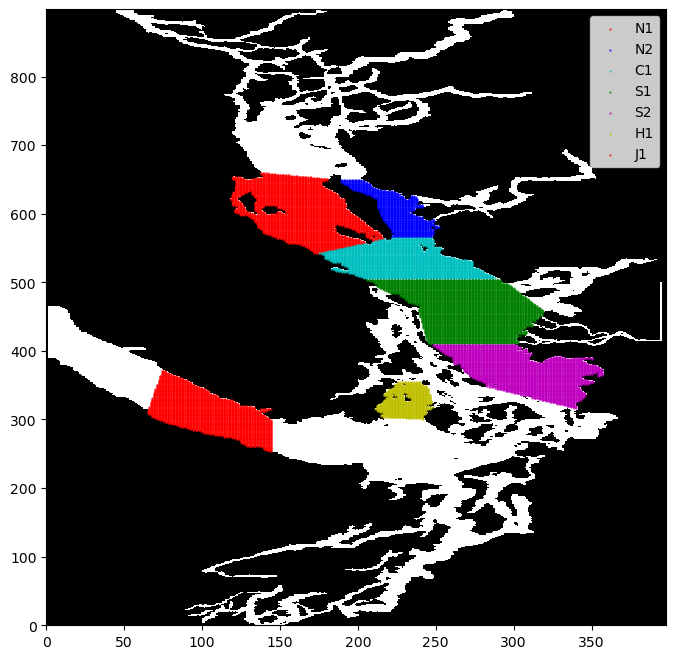

In [18]:
fig, ax = plt.subplots(figsize = (8,8))
ax.pcolormesh(mask['tmask'][0][0], cmap = 'grey')
ax.scatter(points_x_N1,points_y_N1, s= .2, color = 'r', label = 'N1')
ax.scatter(points_x_N2,points_y_N2, s= .2, color = 'b', label = 'N2')
ax.scatter(points_x_C1,points_y_C1, s= .2, color = 'c', label = 'C1')
ax.scatter(points_x_S1,points_y_S1, s= .2, color = 'g', label = 'S1')
ax.scatter(points_x_S2,points_y_S2, s= .2, color = 'm', label = 'S2')
ax.scatter(points_x_H1,points_y_H1, s= .2, color = 'y', label = 'H1')
ax.scatter(points_x_J1,points_y_J1, s= .2, color = 'r', label = 'J1')
#
ax.legend()

**Now that we have grid points and areas of each polygon, lets convert that into latitudes and longitudes for comparing with particles coordinates**

In [19]:
# Northern Strait
# Subregion Left
N1_lon_1, N1_lat_1 = [mask.nav_lon[Ny1_1[0],Nx1_1[0]].values, mask.nav_lon[Ny1_1[1],Nx1_1[1]].values], [mask.nav_lat[Ny1_1[0],Nx1_1[0]].values, mask.nav_lat[Ny1_1[1],Nx1_1[1]].values]
N1_lon_2, N1_lat_2 = [mask.nav_lon[Ny1_2[0],Nx1_2[0]].values, mask.nav_lon[Ny1_2[1],Nx1_2[1]].values], [mask.nav_lat[Ny1_2[0],Nx1_2[0]].values, mask.nav_lat[Ny1_2[1],Nx1_2[1]].values]
#
# Subregion Right
N2_lon_1, N2_lat_1 = [mask.nav_lon[Ny2_1[0],Nx2_1[0]].values, mask.nav_lon[Ny2_1[1],Nx2_1[1]].values], [mask.nav_lat[Ny2_1[0],Nx2_1[0]].values, mask.nav_lat[Ny2_1[1],Nx2_1[1]].values]
N2_lon_2, N2_lat_2 = [mask.nav_lon[Ny2_2[0],Nx2_2[0]].values, mask.nav_lon[Ny2_2[1],Nx2_2[1]].values], [mask.nav_lat[Ny2_2[0],Nx2_2[0]].values, mask.nav_lat[Ny2_2[1],Nx2_2[1]].values]
N2_lon_3, N2_lat_3 = [mask.nav_lon[Ny2_3[0],Nx2_3[0]].values, mask.nav_lon[Ny2_3[1],Nx2_3[1]].values], [mask.nav_lat[Ny2_3[0],Nx2_3[0]].values, mask.nav_lat[Ny2_3[1],Nx2_3[1]].values]
#
# Central Strait
C1_lon_1, C1_lat_1 = [mask.nav_lon[Cy1_1[0],Cx1_1[0]].values, mask.nav_lon[Cy1_1[1],Cx1_1[1]].values], [mask.nav_lat[Cy1_1[0],Cx1_1[0]].values, mask.nav_lat[Cy1_1[1],Cx1_1[1]].values]
C1_lon_2, C1_lat_2 = [mask.nav_lon[Cy1_2[0],Cx1_2[0]].values, mask.nav_lon[Cy1_2[1],Cx1_2[1]].values], [mask.nav_lat[Cy1_2[0],Cx1_2[0]].values, mask.nav_lat[Cy1_2[1],Cx1_2[1]].values]
C1_lon_3, C1_lat_3 = [mask.nav_lon[Cy1_3[0],Cx1_3[0]].values, mask.nav_lon[Cy1_3[1],Cx1_3[1]].values], [mask.nav_lat[Cy1_3[0],Cx1_3[0]].values, mask.nav_lat[Cy1_3[1],Cx1_3[1]].values]
C1_lon_4, C1_lat_4 = [mask.nav_lon[Cy1_4[0],Cx1_4[0]].values, mask.nav_lon[Cy1_4[1],Cx1_4[1]].values], [mask.nav_lat[Cy1_4[0],Cx1_4[0]].values, mask.nav_lat[Cy1_4[1],Cx1_4[1]].values]
C1_lon_5, C1_lat_5 = [mask.nav_lon[Cy1_5[0],Cx1_5[0]].values, mask.nav_lon[Cy1_5[1],Cx1_5[1]].values], [mask.nav_lat[Cy1_5[0],Cx1_5[0]].values, mask.nav_lat[Cy1_5[1],Cx1_5[1]].values]
# Southern Strait
# Subregion North
S1_lon_1, S1_lat_1 = [mask.nav_lon[Sy1_1[0],Sx1_1[0]].values, mask.nav_lon[Sy1_1[1],Sx1_1[1]].values], [mask.nav_lat[Sy1_1[0],Sx1_1[0]].values, mask.nav_lat[Sy1_1[1],Sx1_1[1]].values]
S1_lon_2, S1_lat_2 = [mask.nav_lon[Sy1_2[0],Sx1_2[0]].values, mask.nav_lon[Sy1_2[1],Sx1_2[1]].values], [mask.nav_lat[Sy1_2[0],Sx1_2[0]].values, mask.nav_lat[Sy1_2[1],Sx1_2[1]].values]
S1_lon_3, S1_lat_3 = [mask.nav_lon[Sy1_3[0],Sx1_3[0]].values, mask.nav_lon[Sy1_3[1],Sx1_3[1]].values], [mask.nav_lat[Sy1_3[0],Sx1_3[0]].values, mask.nav_lat[Sy1_3[1],Sx1_3[1]].values]
S1_lon_4, S1_lat_4 = [mask.nav_lon[Sy1_4[0],Sx1_4[0]].values, mask.nav_lon[Sy1_4[1],Sx1_4[1]].values], [mask.nav_lat[Sy1_4[0],Sx1_4[0]].values, mask.nav_lat[Sy1_4[1],Sx1_4[1]].values]
S1_lon_5, S1_lat_5 = [mask.nav_lon[Sy1_5[0],Sx1_5[0]].values, mask.nav_lon[Sy1_5[1],Sx1_5[1]].values], [mask.nav_lat[Sy1_5[0],Sx1_5[0]].values, mask.nav_lat[Sy1_5[1],Sx1_5[1]].values]
S1_lon_6, S1_lat_6 = [mask.nav_lon[Sy1_6[0],Sx1_6[0]].values, mask.nav_lon[Sy1_6[1],Sx1_6[1]].values], [mask.nav_lat[Sy1_6[0],Sx1_6[0]].values, mask.nav_lat[Sy1_6[1],Sx1_6[1]].values]
# Subregion South
S2_lon_1, S2_lat_1 = [mask.nav_lon[Sy2_1[0],Sx2_1[0]].values, mask.nav_lon[Sy2_1[1],Sx2_1[1]].values], [mask.nav_lat[Sy2_1[0],Sx2_1[0]].values, mask.nav_lat[Sy2_1[1],Sx2_1[1]].values]
S2_lon_2, S2_lat_2 = [mask.nav_lon[Sy2_2[0],Sx2_2[0]].values, mask.nav_lon[Sy2_2[1],Sx2_2[1]].values], [mask.nav_lat[Sy2_2[0],Sx2_2[0]].values, mask.nav_lat[Sy2_2[1],Sx2_2[1]].values]
S2_lon_3, S2_lat_3 = [mask.nav_lon[Sy2_3[0],Sx2_3[0]].values, mask.nav_lon[Sy2_3[1],Sx2_3[1]].values], [mask.nav_lat[Sy2_3[0],Sx2_3[0]].values, mask.nav_lat[Sy2_3[1],Sx2_3[1]].values]
S2_lon_4, S2_lat_4 = [mask.nav_lon[Sy2_4[0],Sx2_4[0]].values, mask.nav_lon[Sy2_4[1],Sx2_4[1]].values], [mask.nav_lat[Sy2_4[0],Sx2_4[0]].values, mask.nav_lat[Sy2_4[1],Sx2_4[1]].values]
#
# Haro Strait
H1_lon_1, H1_lat_1 = [mask.nav_lon[Hy1_1[0],Hx1_1[0]].values, mask.nav_lon[Hy1_1[1],Hx1_1[1]].values], [mask.nav_lat[Hy1_1[0],Hx1_1[0]].values, mask.nav_lat[Hy1_1[1],Hx1_1[1]].values]
H1_lon_2, H1_lat_2 = [mask.nav_lon[Hy1_2[0],Hx1_2[0]].values, mask.nav_lon[Hy1_2[1],Hx1_2[1]].values], [mask.nav_lat[Hy1_2[0],Hx1_2[0]].values, mask.nav_lat[Hy1_2[1],Hx1_2[1]].values]
H1_lon_3, H1_lat_3 = [mask.nav_lon[Hy1_3[0],Hx1_3[0]].values, mask.nav_lon[Hy1_3[1],Hx1_3[1]].values], [mask.nav_lat[Hy1_3[0],Hx1_3[0]].values, mask.nav_lat[Hy1_3[1],Hx1_3[1]].values]#
#
# Juan de Fuca Strait
J1_lon_1, J1_lat_1 = [mask.nav_lon[Jy1_1[0],Jx1_1[0]].values, mask.nav_lon[Jy1_1[1],Jx1_1[1]].values], [mask.nav_lat[Jy1_1[0],Jx1_1[0]].values, mask.nav_lat[Jy1_1[1],Jx1_1[1]].values]
J1_lon_2, J1_lat_2 = [mask.nav_lon[Jy1_2[0],Jx1_2[0]].values, mask.nav_lon[Jy1_2[1],Jx1_2[1]].values], [mask.nav_lat[Jy1_2[0],Jx1_2[0]].values, mask.nav_lat[Jy1_2[1],Jx1_2[1]].values]
J1_lon_3, J1_lat_3 = [mask.nav_lon[Jy1_3[0],Jx1_3[0]].values, mask.nav_lon[Jy1_3[1],Jx1_3[1]].values], [mask.nav_lat[Jy1_3[0],Jx1_3[0]].values, mask.nav_lat[Jy1_3[1],Jx1_3[1]].values]#

Coordinates of Sun et. al 2023 sampling stations:

In [20]:
stations = ['JF2', 'HS', 'S4-1.5', 'S2', 'NG', 'S1', 'S3', 'FR']
lat = np.array([48 + (18/60), 48 + (37.80/60) , 49 + (15/60) , 49 + (17.58/60) , 49 + (43.60/60), 49 + (12.32/60), 49 + (17.88/60), 49 + (08.66/60)])
lon = (-1) * np.array([124, 123 + (14.60/60), 123 + (40/60), 123 + (22.51/60), 124 + (40.80/60), 123 + (18/60), 123 + (04.91/60), 123 + (02.65/60)]) 

/tmp/ipykernel_1983982/2844909546.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = 'grey')


Text(0.5, 1.0, '4 Regions for Analysis (based on Sun et. al 2023 sampling locations)')

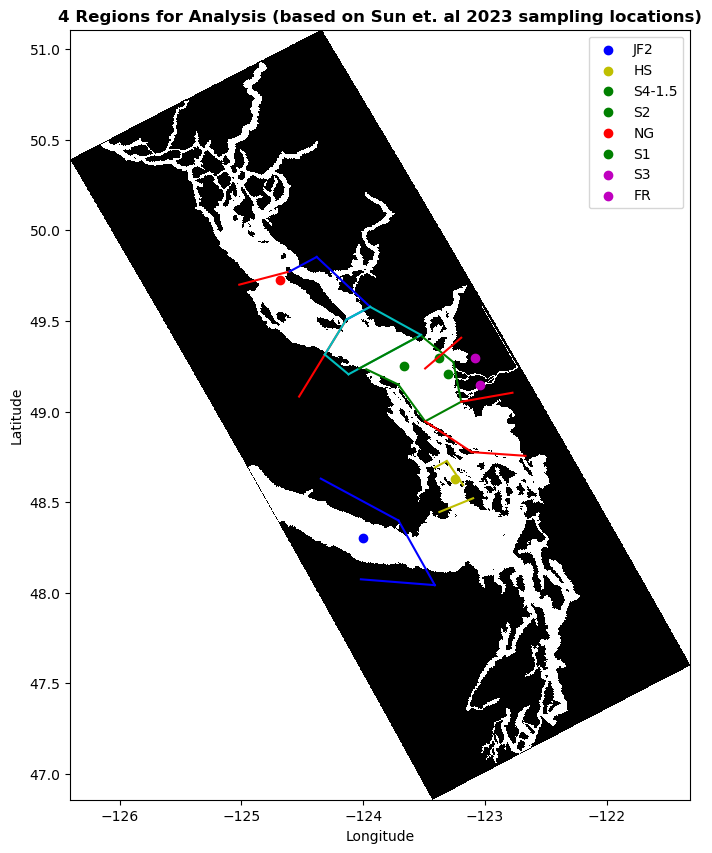

In [21]:
fig, ax = plt.subplots(figsize = (8,10))
#
ax.plot(N1_lon_1, N1_lat_1, 'r')
ax.plot(N1_lon_2, N1_lat_2, 'r')
#
ax.plot(N2_lon_1, N2_lat_1, 'b')
ax.plot(N2_lon_2, N2_lat_2, 'b')
ax.plot(N2_lon_3, N2_lat_3, 'b')
#
ax.plot(C1_lon_1, C1_lat_1, 'c')
ax.plot(C1_lon_2, C1_lat_2, 'c')
ax.plot(C1_lon_3, C1_lat_3, 'c')
ax.plot(C1_lon_4, C1_lat_4, 'c')
ax.plot(C1_lon_5, C1_lat_5, 'c')
#
ax.plot(S1_lon_1, S1_lat_1, 'g')
ax.plot(S1_lon_2, S1_lat_2, 'g')
ax.plot(S1_lon_3, S1_lat_3, 'g')
ax.plot(S1_lon_4, S1_lat_4, 'g')
ax.plot(S1_lon_5, S1_lat_5, 'g')
ax.plot(S1_lon_6, S1_lat_6, 'g')
#
ax.plot(S2_lon_1, S1_lat_1, 'r')
ax.plot(S2_lon_2, S2_lat_2, 'r')
ax.plot(S2_lon_3, S2_lat_3, 'r')
ax.plot(S2_lon_4, S2_lat_4, 'r')
#
ax.plot(H1_lon_1, H1_lat_1, 'y')
ax.plot(H1_lon_2, H1_lat_2, 'y')
ax.plot(H1_lon_3, H1_lat_3, 'y')
#
ax.plot(J1_lon_1, J1_lat_1, 'b')
ax.plot(J1_lon_2, J1_lat_2, 'b')
ax.plot(J1_lon_3, J1_lat_3, 'b')

#
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = 'grey')

#
colors = ['b','y','g','g','r','g','m','m']
for i in range(len(stations)):
    ax.scatter(lon[i], lat[i], c = colors[i], label = stations[i])
ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('4 Regions for Analysis (based on Sun et. al 2023 sampling locations)', fontweight = 'bold')

See how to isolate what's inside each box

In [22]:
nav_lon = mask['nav_lon']
nav_lat = mask['nav_lat']
tmask = mask['tmask'][0][0]

**Northern Strait Polygon**

Subregion Left

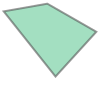

In [23]:
polygon_lon_lat_N1 = [
    (N1_lon_1[0], N1_lat_1[0]),
    (N1_lon_1[1], N1_lat_1[1]),
    (N1_lon_2[1], N1_lat_2[1]),
    (N1_lon_2[0], N1_lat_2[0]),
    (N1_lon_1[0], N1_lat_1[0])
]
polygon_coors_N1 = Polygon(polygon_lon_lat_N1)
polygon_coors_N1

Subregion Right

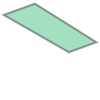

In [24]:
polygon_lon_lat_N2 = [
    (N2_lon_3[0], N2_lat_3[0]),
    (N2_lon_1[0], N2_lat_1[0]),
    (N2_lon_2[1], N2_lat_2[1]),
    (N2_lon_2[0], N2_lat_2[0])
]
polygon_coors_N2 = Polygon(polygon_lon_lat_N2)
polygon_coors_N2

**Central Strait Polygon**

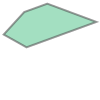

In [25]:
polygon_lon_lat_C1 = [
    (C1_lon_1[1], C1_lat_1[1]),
    (C1_lon_1[0], C1_lat_1[0]),
    (C1_lon_2[0], C1_lat_2[0]),
    (C1_lon_2[1], C1_lat_2[1]),
    (C1_lon_3[1], C1_lat_3[1]),
    (C1_lon_4[1], C1_lat_4[1])
]
polygon_coors_C1 = Polygon(polygon_lon_lat_C1)
polygon_coors_C1

**Southern Strait Polygon**

Subregion North

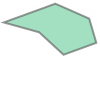

In [26]:
polygon_lon_lat_S1 = [
    (S1_lon_1[0], S1_lat_1[0]),
    (S1_lon_1[1], S1_lat_1[1]),
    (S1_lon_2[1], S1_lat_2[1]),
    (S1_lon_5[1], S1_lat_5[1]),
    (S1_lon_6[0], S1_lat_6[0]),
    (S1_lon_4[0], S1_lat_4[0])
]
polygon_coors_S1 = Polygon(polygon_lon_lat_S1)
polygon_coors_S1

Subregion South

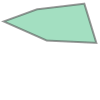

In [27]:
polygon_lon_lat_S2 = [
    (S2_lon_1[1], S2_lat_1[1]),
    (S2_lon_1[0], S2_lat_1[0]),
    (S2_lon_2[1], S2_lat_2[1]),
    (S2_lon_3[1], S2_lat_3[1]),
    (S2_lon_4[1], S2_lat_4[1])
]
polygon_coors_S2 = Polygon(polygon_lon_lat_S2)
polygon_coors_S2

**Haro Strait Polygon**

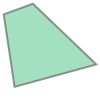

In [28]:
polygon_lon_lat_H1 = [
    (H1_lon_1[1], H1_lat_1[1]),
    (H1_lon_1[0], H1_lat_1[0]),
    (H1_lon_2[0], H1_lat_2[0]),
    (H1_lon_3[0], H1_lat_3[0])

]
polygon_coors_H1 = Polygon(polygon_lon_lat_H1)
polygon_coors_H1

**Juan de Fuca Strait Polygon**

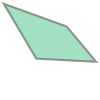

In [29]:
polygon_lon_lat_J1 = [
    (J1_lon_1[0], J1_lat_1[0]),
    (J1_lon_1[1], J1_lat_1[1]),
    (J1_lon_2[1], J1_lat_2[1]),
    (J1_lon_3[1], J1_lat_3[1])

]
polygon_coors_J1 = Polygon(polygon_lon_lat_J1)
polygon_coors_J1

In [30]:
def inside_polygon_lon_lat(polygon, mask_path = path['mask']):
    #
    mask = xr.open_dataset(mask_path)
    nav_lon = mask['nav_lon'].values
    nav_lat = mask['nav_lat'].values
    tmask = mask['tmask'][0, 0].values
    # 
    nav_lon_flat = nav_lon.ravel()
    nav_lat_flat = nav_lat.ravel()
    tmask_flat = tmask.ravel()
    #
    points = np.array([Point(lon, lat) for lon, lat in zip(nav_lon_flat, nav_lat_flat)])
    #
    inside_mask = np.array([polygon.contains(point) for point in points]) & (tmask_flat == 1)
    #
    longitudes = nav_lon_flat[inside_mask]
    latitudes = nav_lat_flat[inside_mask]
    #
    return longitudes, latitudes 

In [31]:
lon_NSoG_N1, lat_NSoG_N1 = inside_polygon_lon_lat(polygon_coors_N1)
lon_NSoG_N2, lat_NSoG_N2 = inside_polygon_lon_lat(polygon_coors_N2)
lon_CSoG_C1, lat_CSoG_C1 = inside_polygon_lon_lat(polygon_coors_C1)
lon_SSoG_S1, lat_SSoG_S1 = inside_polygon_lon_lat(polygon_coors_S1)
lon_SSoG_S2, lat_SSoG_S2 = inside_polygon_lon_lat(polygon_coors_S2)
lon_Haro_H1, lat_Haro_H1 = inside_polygon_lon_lat(polygon_coors_H1)
lon_Juan_J1, lat_Juan_J1 = inside_polygon_lon_lat(polygon_coors_J1)

/tmp/ipykernel_1983982/1979788646.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')


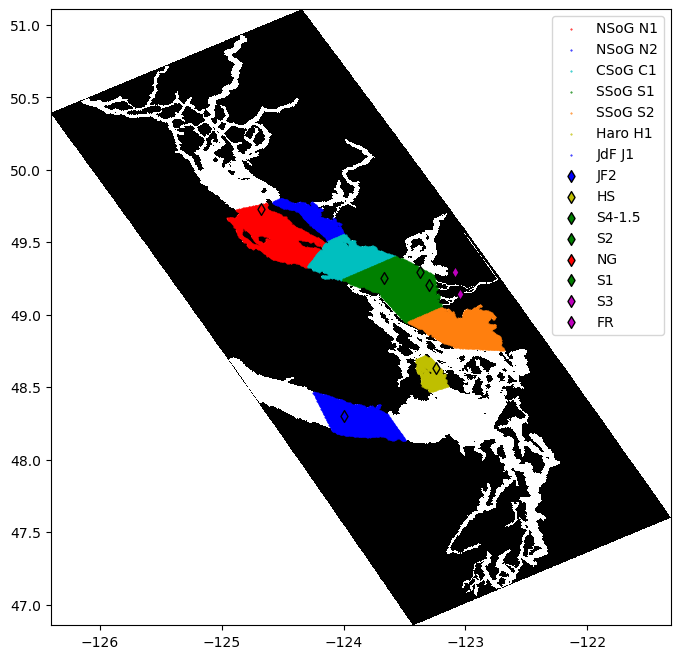

In [32]:
fig, ax = plt.subplots(figsize = (8,8))
ax.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')
ax.scatter(lon_NSoG_N1, lat_NSoG_N1, s= .2, color = 'r', label = 'NSoG N1')
ax.scatter(lon_NSoG_N2, lat_NSoG_N2, s= .2, color = 'b', label = 'NSoG N2')
#
ax.scatter(lon_CSoG_C1, lat_CSoG_C1, s= .2, color = 'c', label = 'CSoG C1')
#
ax.scatter(lon_SSoG_S1, lat_SSoG_S1, s= .2, color = 'g', label = 'SSoG S1')
ax.scatter(lon_SSoG_S2, lat_SSoG_S2, s= .2, color = 'tab:orange', label = 'SSoG S2')
#
ax.scatter(lon_Haro_H1, lat_Haro_H1, s= .2, color = 'y', label = 'Haro H1')
ax.scatter(lon_Juan_J1, lat_Juan_J1, s= .2, color = 'b', label = 'JdF J1')
#
colors = ['b','y','g','g','r','g','m','m']
for i in range(len(stations)):
    ax.scatter(lon[i], lat[i], marker = 'd', edgecolors='k', c = colors[i], label = stations[i])
ax.legend()
ax.legend()

**Testing for a monthly run:**

In [33]:
name_file = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/PBDEs_run_for_30_days_500_particles_20220101_1n_20220131_1n.zarr'
data = xr.open_zarr(name_file)

In [34]:
def points_inside(polygon, data, t):
    #
    lon_values = data.lon[:, t].values
    lat_values = data.lat[:, t].values
    depth_values =  data.z[:,t].values / data.fact[:,t].values
    status_values = data.status[:, t].values
    #
    points = np.array([Point(lon, lat) for lon, lat in zip(lon_values, lat_values)])
    #    
    inside_mask = np.array([polygon.contains(point) for point in points])
    #
    longitudes = lon_values[inside_mask]
    latitudes = lat_values[inside_mask]
    status_inside = status_values[inside_mask].astype(int)
    depth_inside = depth_values[inside_mask]
    #
    amount = np.sum(inside_mask)
    #
    return depth_inside, longitudes, latitudes, status_inside, amount

In [35]:
tt = 100
depth_N1, long_N1, lati_N1, status_inside_N1, amount_N1 = points_inside(polygon_coors_N1, data, t = tt)
depth_N2, long_N2, lati_N2, status_inside_N2, amount_N2 = points_inside(polygon_coors_N2, data, t = tt)
depth_C1, long_C1, lati_C1, status_inside_C1, amount_C1 = points_inside(polygon_coors_C1, data, t = tt)
depth_S1, long_S1, lati_S1, status_inside_S1, amount_S1 = points_inside(polygon_coors_S1, data, t = tt)
depth_S2, long_S2, lati_S2, status_inside_S2, amount_S2 = points_inside(polygon_coors_S2, data, t = tt)
depth_H1, long_H1, lati_H1, status_inside_H1, amount_H1 = points_inside(polygon_coors_H1, data, t = tt)
depth_J1, long_J1, lati_J1, status_inside_J1, amount_J1 = points_inside(polygon_coors_J1, data, t = tt)


/tmp/ipykernel_1983982/3362386007.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')


Text(0.5, 1.0, 'Testing Monthly Run (500 Particles)')

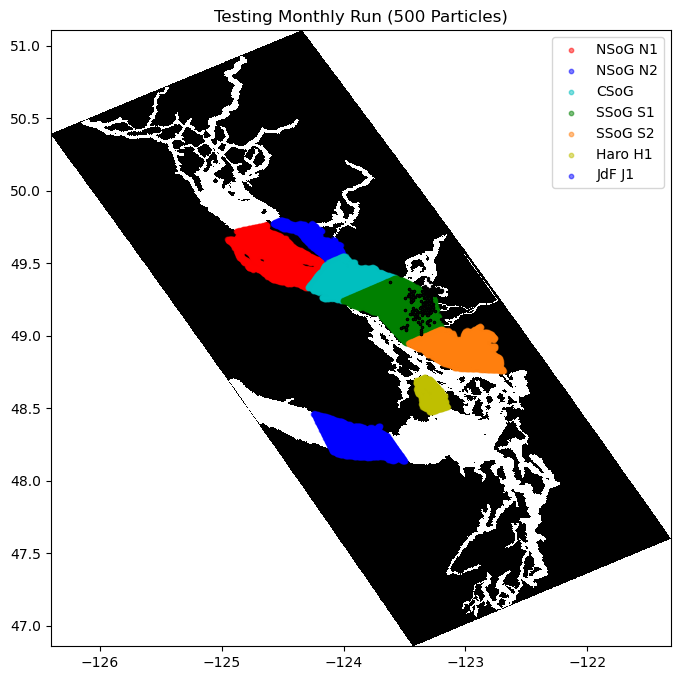

In [36]:
fig, ax = plt.subplots(figsize = (8,8))
ax.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')
ax.scatter(lon_NSoG_N1, lat_NSoG_N1, s= 10, color = 'r',  alpha = .5,  label = 'NSoG N1')
ax.scatter(lon_NSoG_N2, lat_NSoG_N2, s= 10, color = 'b',  alpha = .5,  label = 'NSoG N2')
#
ax.scatter(lon_CSoG_C1, lat_CSoG_C1, s= 10, color = 'c',  alpha = .5,  label = 'CSoG')
#
ax.scatter(lon_SSoG_S1, lat_SSoG_S1, s= 10, color = 'g', alpha = .5, label = 'SSoG S1')
ax.scatter(lon_SSoG_S2, lat_SSoG_S2, s= 10, color = 'tab:orange', alpha = .5, label = 'SSoG S2')
#
ax.scatter(lon_Haro_H1, lat_Haro_H1, s= 10, color = 'y', alpha = .5, label = 'Haro H1')
#
ax.scatter(lon_Juan_J1, lat_Juan_J1, s= 10, color = 'b', alpha = .5, label = 'JdF J1')
ax.legend()
#
ax.scatter(data.lon[:,tt],data.lat[:,tt], c = 'k', s=2)
#
ax.scatter(long_N1, lati_N1, s= 2, c = 'r', edgecolors='k')
ax.scatter(long_N2, lati_N2, s= 2, c = 'r', edgecolors='k')
ax.scatter(long_C1, lati_C1, s= 2, c = 'g', edgecolors='k')
ax.scatter(long_S1, lati_S1, s= 2, c = 'g', edgecolors='k')
ax.scatter(long_S2, lati_S2, s= 2, c = 'g', edgecolors='k')
ax.scatter(long_H1, lati_H1, s= 2, c = 'y', edgecolors='k')
ax.scatter(long_J1, lati_J1, s= 2, c = 'b', edgecolors='k')
#
ax.set_title('Testing Monthly Run (500 Particles)')

**Get the amount of particles that are inside the polygons at every timestep**

In [37]:
n_steps = len(data.obs)
polygons_dict = {
    'N1': (polygon_coors_N1, np.zeros(n_steps, dtype=int)),
    'N2': (polygon_coors_N2, np.zeros(n_steps, dtype=int)),
    'C1': (polygon_coors_C1, np.zeros(n_steps, dtype=int)),
    'S1': (polygon_coors_S1, np.zeros(n_steps, dtype=int)),
    'S2': (polygon_coors_S2, np.zeros(n_steps, dtype=int)),
    'H1': (polygon_coors_H1, np.zeros(n_steps, dtype=int)),
    'J1': (polygon_coors_J1, np.zeros(n_steps, dtype=int))
}
# 
for i in range(n_steps):
    for key, (polygon, particle_array) in polygons_dict.items():
        _, _, _, _, n_part = points_inside(polygon, data, t=i)
        particle_array[i] = n_part
#
n_particles_SSoG_N1 = polygons_dict['N1'][1]
n_particles_SSoG_N2 = polygons_dict['N2'][1]
n_particles_SSoG_C1 = polygons_dict['C1'][1]
n_particles_SSoG_S1 = polygons_dict['S1'][1]
n_particles_SSoG_S2 = polygons_dict['S2'][1]
n_particles_SSoG_H1 = polygons_dict['H1'][1]
n_particles_SSoG_J1 = polygons_dict['J1'][1]  

In [38]:
n_steps = len(data.obs)
outputs = ['depth', 'lon', 'lat', 'status', 'n_particles']
polygons_dict = {
    'N1': (polygon_coors_N1, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object)),
    'N2': (polygon_coors_N2, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object)),
    'C1': (polygon_coors_C1, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object)),
    'S1': (polygon_coors_S1, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object)),
    'S2': (polygon_coors_S2, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object)),
    'H1': (polygon_coors_H1, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object)),
    'J1': (polygon_coors_J1, pd.DataFrame(columns=outputs, index=np.arange(0,n_steps), dtype=object))
}
for i in range(n_steps):
    for key, (polygon, data_sets) in polygons_dict.items():
        depth_region, lon_region, lat_region, status_region, n_part = points_inside(polygon, data, t=i)
        data_sets.iloc[i] = [depth_region, lon_region, lat_region, status_region, n_part]  

---------------------------------------------------------

**Vertical distribution**

In [39]:
def vertical_mean_profiles(polygon_section, v_resolution):
    PROF = np.linspace(0, int(mask['totaldepth'].max().values), v_resolution)
    DATA_depth_mean = pd.DataFrame(columns=['Avg. Depth', 'Avg. Particles '])
    #
    for k in range(len(PROF)-1):
        bin_depths = []  
        particles_per_row = []  
        #
        for jj in range(len(polygon_section[1])):
            depths = polygon_section[1].iloc[jj].depth
            #
            depths_in_bin = depths[(depths >= PROF[k]) & (depths < PROF[k+1])]
            
            if len(depths_in_bin) > 0:
                bin_depths.extend(depths_in_bin) 
                particles_per_row.append(len(depths_in_bin)) 
        #
        avg_depth = np.nanmean(bin_depths) if bin_depths else np.nan
        avg_particles = np.nanmean(particles_per_row) if particles_per_row else 0
        DATA_depth_mean.at[k, 'Avg. Depth'] = avg_depth
        DATA_depth_mean.at[k, 'Avg. Particles'] = avg_particles
    ############## For the last Bin ###############
    k = len(PROF)-1
    bin_depths = []
    particles_per_row = []
    for jj in range(len(polygon_section[1])):
        depths = polygon_section[1].iloc[jj].depth
        #
        depths_in_bin = depths[(depths >= PROF[-2]) & (depths < PROF[-1])]  #
        if len(depths_in_bin) > 0:
            bin_depths.extend(depths_in_bin)
            particles_per_row.append(len(depths_in_bin))

    avg_depth = np.nanmean(bin_depths) if bin_depths else np.nan
    avg_particles = np.nanmean(particles_per_row) if particles_per_row else 0
    DATA_depth_mean.at[k, 'Avg. Depth'] = avg_depth
    DATA_depth_mean.at[k, 'Avg. Particles'] = avg_particles    
    return DATA_depth_mean    

In [40]:
def vertical_status_profiles(polygon_section, v_resolution):
    # Define depth bins
    PROF = np.linspace(0, int(mask['totaldepth'].max().values), v_resolution)
    
    # Initialize DataFrame for results
    DATA_depth_mean = pd.DataFrame({
        'Avg. Depth': np.nan,
        'Particles Status 1': np.nan,
        'Particles Status 2': np.nan,
        'Particles Status 3': np.nan,
        'Particles Status 4': np.nan
    }, index=range(len(PROF) - 1))

    # Iterate through depth bins
    for k in range(len(PROF) - 1):
        bin_depths = {1: [], 2: [], 3: [], 4: []}  # Collect depths for each status
        particles_per_status = {1: 0, 2: 0, 3: 0, 4: 0}  # Count particles for each status

        # Iterate through each particle in the specified range
        for i in range(len(polygon_section[1])):
            particle = polygon_section[1].iloc[i]
            statuses = particle.status  # Array of statuses
            depths = particle.depth  # Corresponding depths

            # Ensure statuses and depths are array-like and have the same length
            if isinstance(statuses, (np.ndarray, list)) and isinstance(depths, (np.ndarray, list)) and len(statuses) == len(depths):
                for status, depth in zip(statuses, depths):
                    if status in [1, 2, 3, 4] and PROF[k] <= depth < PROF[k + 1]:
                        bin_depths[status].append(depth)
                        particles_per_status[status] += 1

        # Calculate averages for the current bin
        avg_depth = np.nanmean([np.nanmean(bin_depths[status]) for status in bin_depths if bin_depths[status]]) if any(bin_depths.values()) else np.nan
        DATA_depth_mean.at[k, 'Avg. Depth'] = avg_depth
        for status in [1, 2, 3, 4]:
            DATA_depth_mean.at[k, f'Particles Status {status}'] = particles_per_status[status]

    return DATA_depth_mean

In [41]:
clat = [49.195045]
clon = [-123.301956]

Total vertical profiles

In [42]:
vertical_N1 = vertical_mean_profiles(polygons_dict['N1'], 40)
vertical_N2 = vertical_mean_profiles(polygons_dict['N2'], 40)
vertical_C1 = vertical_mean_profiles(polygons_dict['C1'], 40)
vertical_S1 = vertical_mean_profiles(polygons_dict['S1'], 40)
vertical_S2 = vertical_mean_profiles(polygons_dict['S2'], 40)
vertical_H1 = vertical_mean_profiles(polygons_dict['H1'], 40)
vertical_J1 = vertical_mean_profiles(polygons_dict['J1'], 40)

/tmp/ipykernel_1983982/3365248511.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_map.pcolormesh(nav_lon, nav_lat, tmask, cmap='grey', shading='auto')


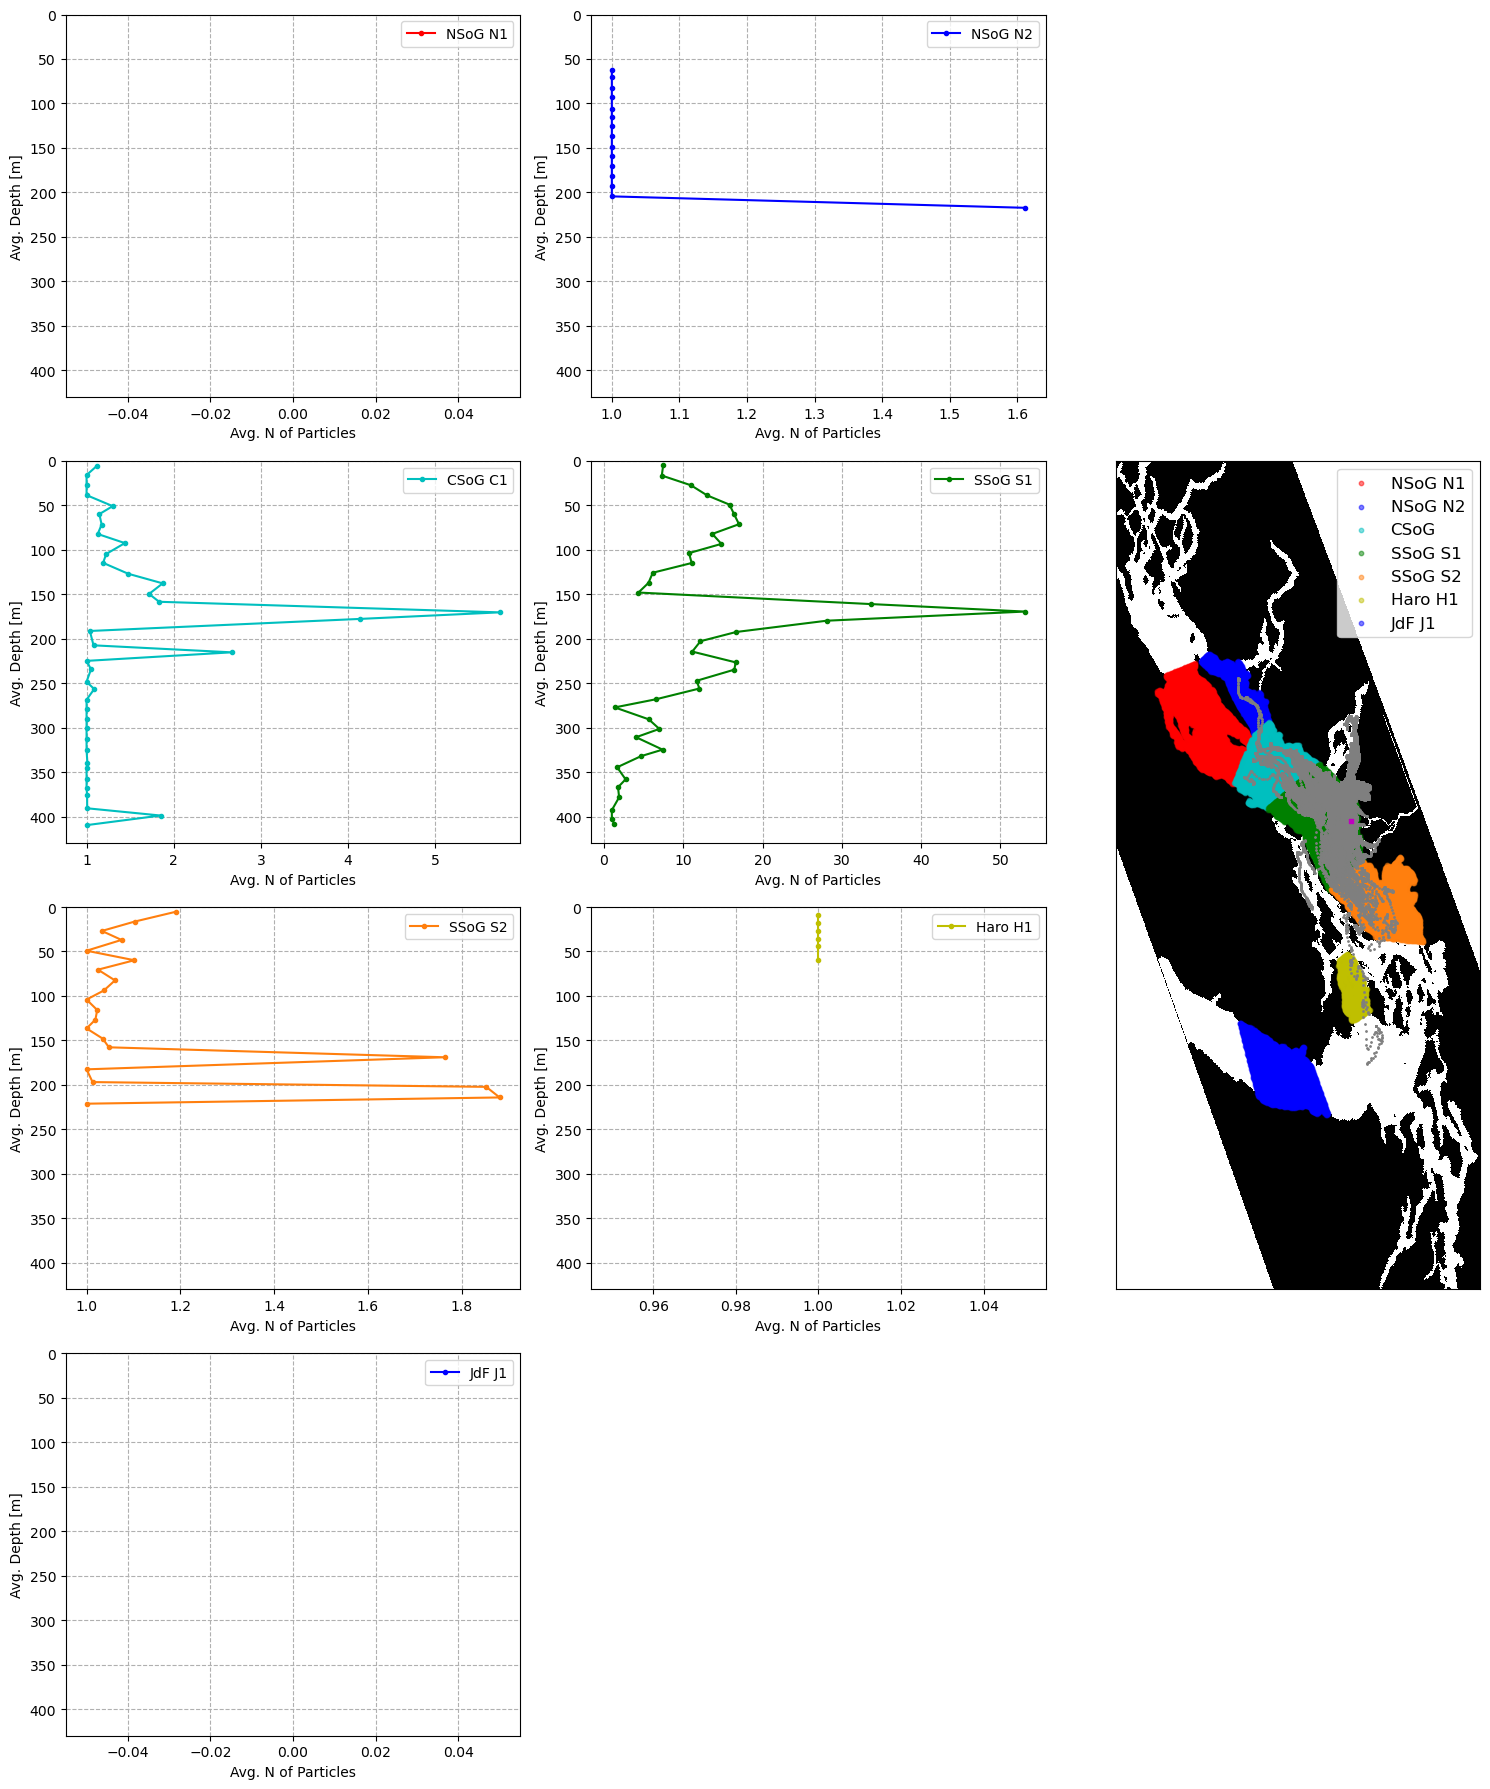

In [43]:
fig = plt.figure(figsize=(15, 18))
gs = fig.add_gridspec(4, 3, width_ratios=[1.0, 1.0, 0.8])
#
ax_plots = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(7)]
#
ax_map = fig.add_subplot(gs[1:3, 2]) 
#
ax_plots[0].plot(vertical_N1['Avg. Particles'], vertical_N1['Avg. Depth'], '.-r', label='NSoG N1')
ax_plots[1].plot(vertical_N2['Avg. Particles'], vertical_N2['Avg. Depth'], '.-b', label='NSoG N2')
ax_plots[2].plot(vertical_C1['Avg. Particles'], vertical_C1['Avg. Depth'], '.-c', label='CSoG C1')
ax_plots[3].plot(vertical_S1['Avg. Particles'], vertical_S1['Avg. Depth'], '.-g', label='SSoG S1')
ax_plots[4].plot(vertical_S2['Avg. Particles'], vertical_S2['Avg. Depth'], 'tab:orange',linestyle='-', marker='.', label='SSoG S2')
ax_plots[5].plot(vertical_H1['Avg. Particles'], vertical_H1['Avg. Depth'], '.-y', label='Haro H1')
ax_plots[6].plot(vertical_J1['Avg. Particles'], vertical_J1['Avg. Depth'], '.-b', label='JdF J1')
#
for ax in ax_plots:
    ax.set_ylim(0, 430)
    ax.invert_yaxis()
    ax.legend(fontsize=10)
    ax.set_xlabel("Avg. N of Particles")
    ax.set_ylabel("Avg. Depth [m]")
    ax.grid(linestyle = '--')
#
ax_map.pcolormesh(nav_lon, nav_lat, tmask, cmap='grey', shading='auto')
ax_map.scatter(lon_NSoG_N1, lat_NSoG_N1, s=10, color='r', alpha=0.5, label='NSoG N1')
ax_map.scatter(lon_NSoG_N2, lat_NSoG_N2, s=10, color='b', alpha=0.5, label='NSoG N2')
ax_map.scatter(lon_CSoG_C1, lat_CSoG_C1, s=10, color='c', alpha=0.5, label='CSoG')
ax_map.scatter(lon_SSoG_S1, lat_SSoG_S1, s=10, color='g', alpha=0.5, label='SSoG S1')
ax_map.scatter(lon_SSoG_S2, lat_SSoG_S2, s=10, color='tab:orange', alpha=0.5, label='SSoG S2')
ax_map.scatter(lon_Haro_H1, lat_Haro_H1, s=10, color='y', alpha=0.5, label='Haro H1')
ax_map.scatter(lon_Juan_J1, lat_Juan_J1, s=10, color='b', alpha=0.5, label='JdF J1')
ax_map.scatter(data.lon, data.lat, s=1, color='tab:gray')
ax_map.scatter(clon[0], clat[0], s=10, color='m', marker='s')
#
ax_map.set_xlim(-125.3, -122.2)
ax_map.set_ylim(47.5, 50.5)
ax_map.legend(fontsize=12)
ax_map.tick_params(
    which='both', bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False,
)
#
fig.tight_layout()
plt.show()

Vertical Profiles for each particle status

In [44]:
status_vertical_N1 = vertical_status_profiles(polygons_dict['N1'], 40)
status_vertical_N2 = vertical_status_profiles(polygons_dict['N2'], 40)
status_vertical_C1 = vertical_status_profiles(polygons_dict['C1'], 40)
status_vertical_S1 = vertical_status_profiles(polygons_dict['S1'], 40)
status_vertical_S2 = vertical_status_profiles(polygons_dict['S2'], 40)
status_vertical_H1 = vertical_status_profiles(polygons_dict['H1'], 40)
status_vertical_J1 = vertical_status_profiles(polygons_dict['J1'], 40)

In [45]:
regions

['N1', 'N2', 'C1', 'S1', 'S2', 'H1', 'J1']

In [46]:
status_label = ['Particles Status 1', 'Particles Status 2', 'Particles Status 3', 'Particles Status 4']
states = ['Sewage Particles', 'Colloids', 'Marine Particles', 'Bottom Particles']
status_profiles = [status_vertical_N1, status_vertical_N2, status_vertical_C1, status_vertical_S1, status_vertical_S2, status_vertical_H1, status_vertical_J1]
colors = ['r', 'b', 'c', 'g', 'tab:orange', 'y', 'yellowgreen']

/tmp/ipykernel_1983982/3429250101.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_map.pcolormesh(nav_lon, nav_lat, tmask, cmap='grey', shading='auto')


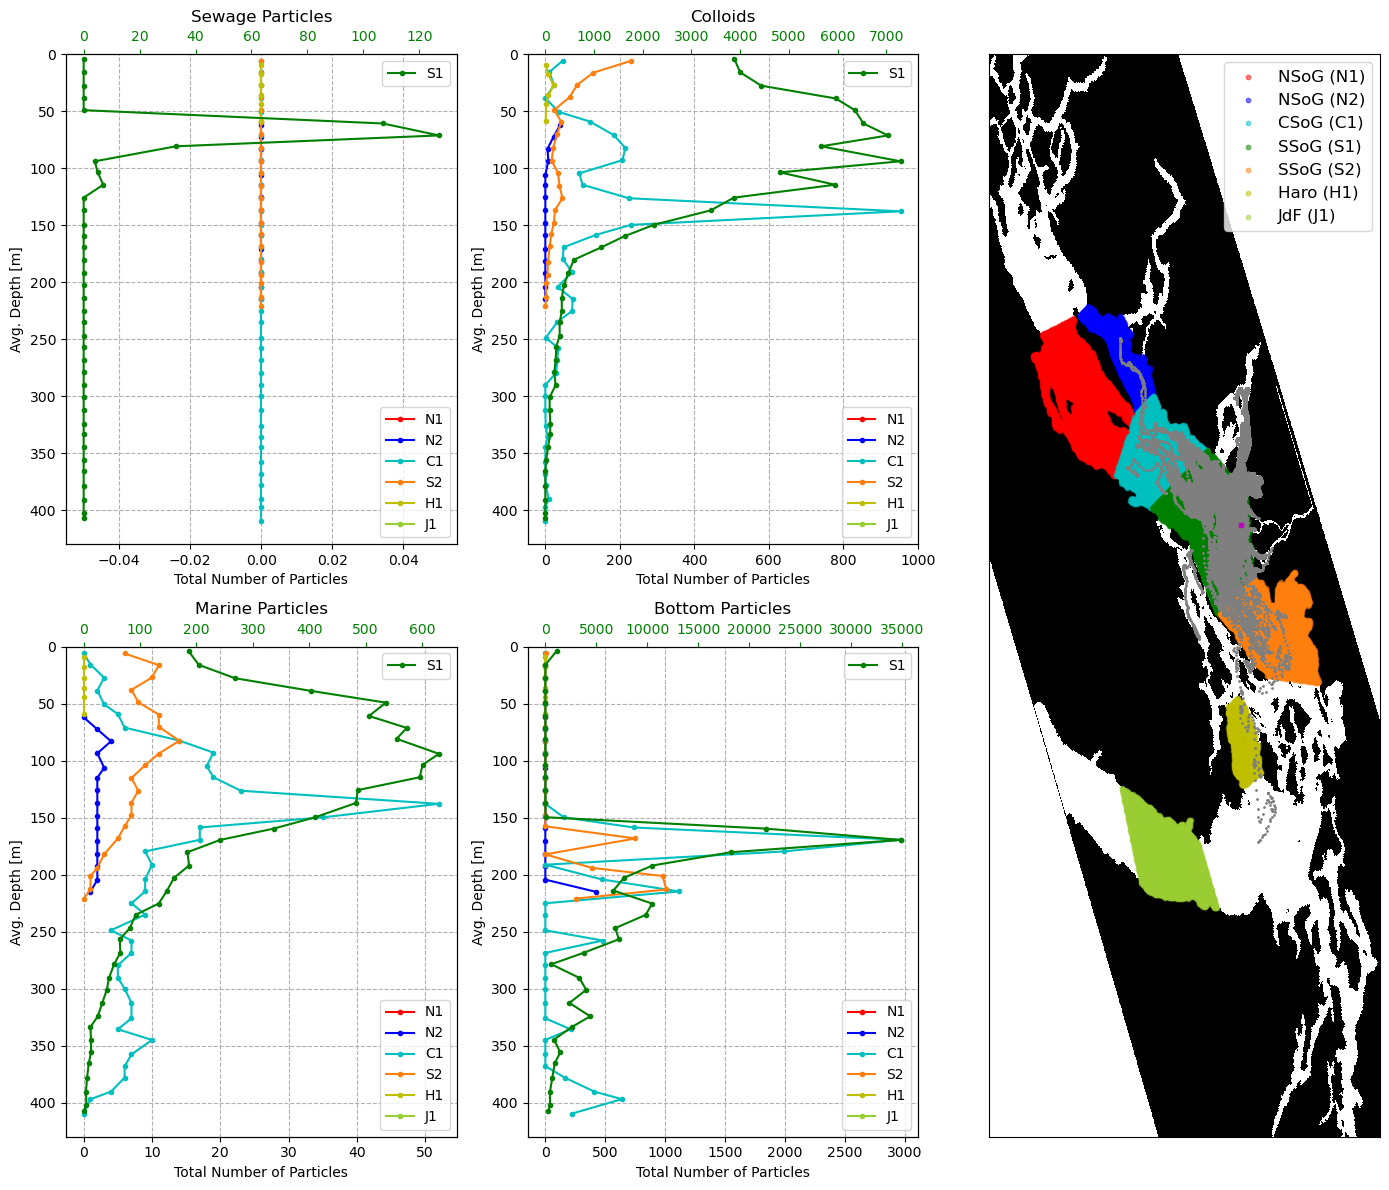

In [47]:
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 3, width_ratios=[1.0, 1.0, 1.0])
#
ax_plots = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
#
ax_map = fig.add_subplot(gs[:, 2]) 
#
for i in range(0, len(status_label)):
    for profile in range(0, len(status_profiles)):
        if profile == 3:
            twin_axis = ax_plots[i].twiny()
            twin_axis.plot(status_profiles[profile][status_label[i]], status_profiles[profile]['Avg. Depth'],colors[profile], label = regions[profile], marker = '.')
            twin_axis.tick_params(axis='x', colors='green')
            twin_axis.legend(loc = 'upper right')
        #    
        else:        
            ax_plots[i].plot(status_profiles[profile][status_label[i]], status_profiles[profile]['Avg. Depth'],colors[profile], label = regions[profile], marker = '.')
            ax_plots[i].set_title(states[i])
            #


#
for ax in ax_plots:
    ax.set_ylim(0, 430)
    ax.invert_yaxis()
    ax.legend(loc = 'lower right', fontsize=10)
    ax.set_xlabel("Total Number of Particles")
    ax.set_ylabel("Avg. Depth [m]")
    ax.grid(linestyle = '--')    
#
# #
ax_map.pcolormesh(nav_lon, nav_lat, tmask, cmap='grey', shading='auto')
ax_map.scatter(lon_NSoG_N1, lat_NSoG_N1, s=10, color='r', alpha=0.5, label='NSoG (N1)')
ax_map.scatter(lon_NSoG_N2, lat_NSoG_N2, s=10, color='b', alpha=0.5, label='NSoG (N2)')
ax_map.scatter(lon_CSoG_C1, lat_CSoG_C1, s=10, color='c', alpha=0.5, label='CSoG (C1)')
ax_map.scatter(lon_SSoG_S1, lat_SSoG_S1, s=10, color='g', alpha=0.5, label='SSoG (S1)')
ax_map.scatter(lon_SSoG_S2, lat_SSoG_S2, s=10, color='tab:orange', alpha=0.5, label='SSoG (S2)')
ax_map.scatter(lon_Haro_H1, lat_Haro_H1, s=10, color='y', alpha=0.5, label='Haro (H1)')
ax_map.scatter(lon_Juan_J1, lat_Juan_J1, s=10, color='yellowgreen', alpha=0.5, label='JdF (J1)')
ax_map.scatter(data.lon, data.lat, s=1, color='tab:gray')
ax_map.scatter(clon[0], clat[0], s=10, color='m', marker='s')
#
ax_map.set_xlim(-125.3, -122.2)
ax_map.set_ylim(47.5, 50.5)
ax_map.legend(fontsize=12)
ax_map.tick_params(
    which='both', bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False,
)
#
fig.tight_layout()
plt.show()         


------------------------
**Concentration Map**

In [48]:
# Create small boxes of, for example, 20 grid points. Get how many particles are inside those boxes and et a concentration map
mask['tmask'][0]

<xarray.DataArray 'tmask' (z: 40, y: 898, x: 398)> Size: 14MB
[14296160 values with dtype=int8]
Dimensions without coordinates: z, y, x

In [49]:
# Boxes sizes based on longitudes and latitudes
num_lon = 30
num_lat = 40
longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon+1)
latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat+1)

In [50]:
def particles_concentration_map(lons, lats, mask=mask, num_lon=30, num_lat=40):
    # Define lon and lat lenght 
    longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon + 1)
    latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat + 1)
    #
    # Particle positions into bins
    lon_indices = np.digitize(lons, longitudes) - 1 
    lat_indices = np.digitize(lats, latitudes) - 1
    #
    amount = np.zeros((num_lon, num_lat))
    #
    valid_mask = (lon_indices >= 0) & (lon_indices < num_lon) & (lat_indices >= 0) & (lat_indices < num_lat)
    lon_indices, lat_indices = lon_indices[valid_mask], lat_indices[valid_mask]
    # Count particles 
    indices = np.ravel_multi_index((lon_indices, lat_indices), dims=(num_lon, num_lat))
    counts = np.bincount(indices, minlength=num_lon * num_lat).reshape((num_lon, num_lat))
    #
    amount[:counts.shape[0], :counts.shape[1]] = counts
    #
    return pd.DataFrame(amount)

In [60]:
data['lon'].values.flatten()

(500, 720)

/tmp/ipykernel_1983982/41151493.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


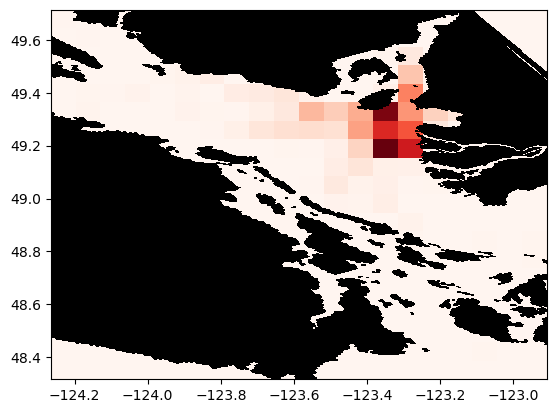

In [ ]:
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
a = plt.hist2d(data['lon'].values.flatten(),data['lat'].values.flatten(), bins = [20,20], cmap = 'Reds')
plt.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


In [51]:
concentration_B = particles_concentration_map(lons=data.where(data['status'] == 4)['lon'], lats=data.where(data['status'] == 4)['lat'])
concentration_MP = particles_concentration_map(lons=data.where(data['status'] == 3)['lon'], lats=data.where(data['status'] == 3)['lat'])
concentration_C = particles_concentration_map(lons=data.where(data['status'] == 2)['lon'], lats=data.where(data['status'] == 2)['lat'])
concentration_SP = particles_concentration_map(lons=data.where(data['status'] == 1)['lon'], lats=data.where(data['status'] == 1)['lat'])
total_concentration = particles_concentration_map(lons=data['lon'], lats=data['lat'])

/tmp/ipykernel_1983982/3847005734.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_1983982/3847005734.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_1983982/3847005734.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case

Text(0.5, 0, 'Longitude')

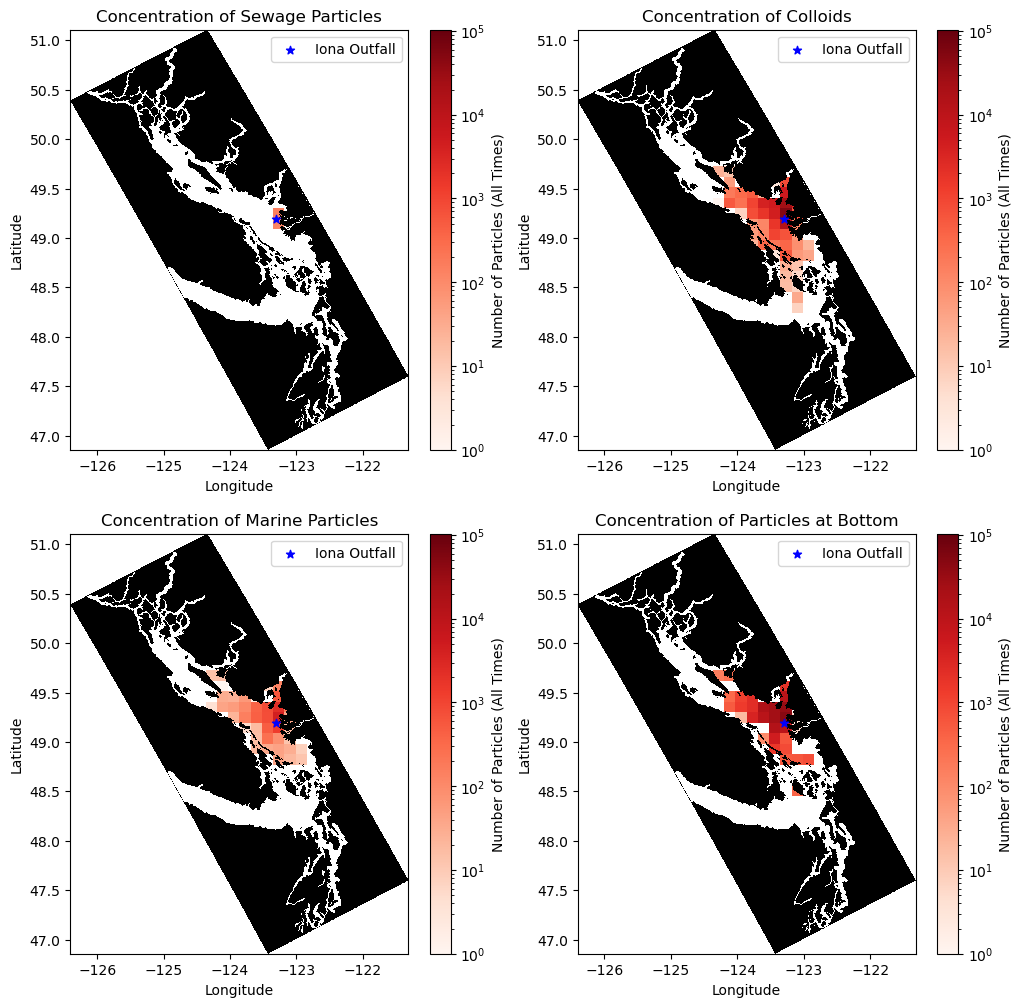

In [52]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
fig, ax = plt.subplots(2,2,figsize=(12,12))
#
sewage = ax[0,0].pcolormesh(longitudes, latitudes, concentration_SP.T, cmap='Reds', norm=LogNorm(vmin=concentration_SP.min().min()+1, vmax=total_concentration.max().max()))
ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,0], label="Number of Particles (All Times)")
ax[0,0].legend()
ax[0,0].set_title('Concentration of Sewage Particles')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_xlabel('Longitude')
#
colloids = ax[0,1].pcolormesh(longitudes, latitudes, concentration_C.T, cmap='Reds', norm=LogNorm(vmin=concentration_C.min().min()+1, vmax=total_concentration.max().max()))
ax[0,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,1], label="Number of Particles (All Times)")
ax[0,1].legend()
ax[0,1].set_title('Concentration of Colloids')
ax[0,1].set_ylabel('Latitude')
ax[0,1].set_xlabel('Longitude')
#
marine = ax[1,0].pcolormesh(longitudes, latitudes, concentration_MP.T, cmap='Reds', norm=LogNorm(vmin=concentration_MP.min().min()+1, vmax=total_concentration.max().max()))
ax[1,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[1,0], label="Number of Particles (All Times)")
ax[1,0].legend()
ax[1,0].set_title('Concentration of Marine Particles')
ax[1,0].set_ylabel('Latitude')
ax[1,0].set_xlabel('Longitude')
#
bottom = ax[1,1].pcolormesh(longitudes, latitudes, concentration_B.T, cmap='Reds', norm=LogNorm(vmin=concentration_B.min().min()+1, vmax=total_concentration.max().max()))
ax[1,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(bottom, ax=ax[1,1], label="Number of Particles (All Times)")
ax[1,1].legend()
ax[1,1].set_title('Concentration of Particles at Bottom')
ax[1,1].set_ylabel('Latitude')
ax[1,1].set_xlabel('Longitude')


In [53]:
# DO THE SAME FOR THE VOLUME AND CALCULATE FOR EACH GRID CELL
# Think about how to do it with the volume, or just consider particle amount instead of concentration...?

/tmp/ipykernel_1983982/3883904909.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


Text(0.5, 0, 'Longitude')

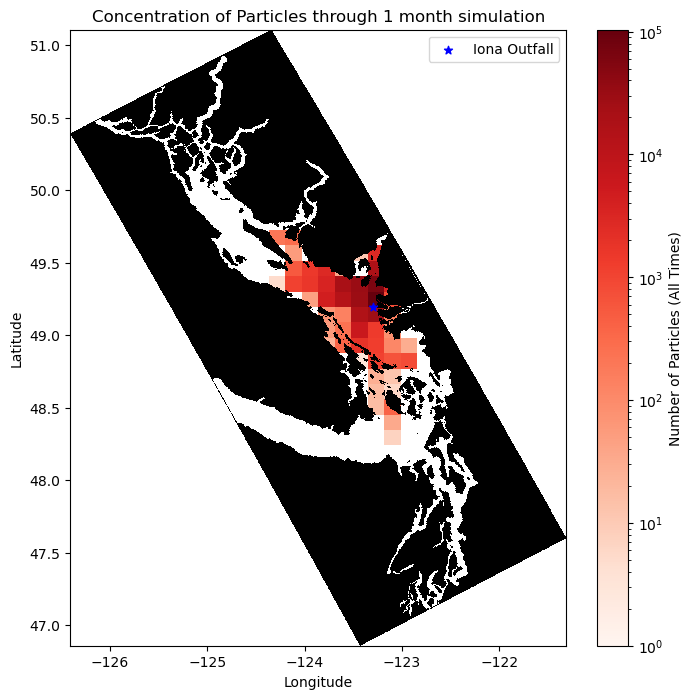

In [54]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
fig, ax = plt.subplots(figsize=(8,8))
c = ax.pcolormesh(longitudes, latitudes, total_concentration.T, cmap='Reds', norm=LogNorm(vmin=total_concentration.min().min()+10e-1, vmax=total_concentration.max().max()))
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
#ax.set_xlim(0,tmask.x[-1])
#ax.set_ylim(0, tmask.y[-1])
#
ax.scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
#
fig.colorbar(c, ax=ax, label="Number of Particles (All Times)")
ax.legend()
#
ax.set_title('Concentration of Particles through 1 month simulation')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

In [60]:
total_volume = mask['volume'].sum(dim="z", skipna=True)

In [45]:
lon_counts = np.arange(0,len(mask['tmask'][0].x),20)
lat_counts = np.arange(0,len(mask['tmask'][0].y),20)
#
container = np.full((len(lon_counts), len(lat_counts)), np.nan)
#
for i in range(0,len(lon_counts)-1):
    for j in range(0,len(lat_counts)-1):
##
# For grid points
        polygon_grid_boxes = [
            (lon_counts[i], lat_counts[j]),
            (lon_counts[i], lat_counts[j+1]),
            (lon_counts[i+1], lat_counts[j+1]),
            (lon_counts[i+1], lat_counts[j])
        ]
        grid_box_square = Polygon(polygon_grid_boxes)
        #
        container[i,j] = polygon_total_volume(grid_box_square)
## Save array in an excel file
#total_volume_boxes = pd.DataFrame(container.T)
#total_volume_boxes.to_csv('total_volume_boxes.csv')       

In [46]:
total_volume_boxes = pd.read_csv('total_volume_boxes.csv')
total_volume_boxes = total_volume_boxes.drop('Unnamed: 0', axis=1)
total_volume_boxes.replace(0.0, np.nan, inplace=True)

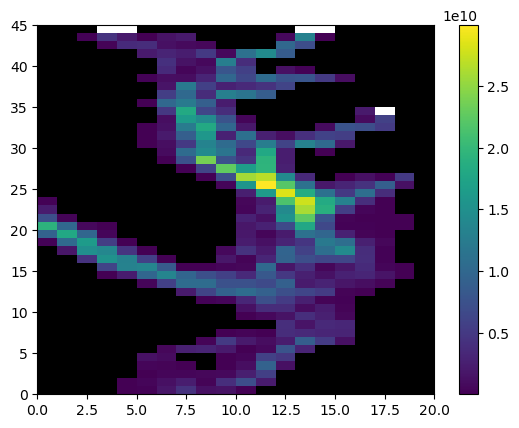

In [47]:
plt.pcolormesh(tmask[lat_counts,lon_counts], cmap = 'gray')
plt.pcolormesh(total_volume_boxes)
plt.colorbar()
# in m^3

Now with longitudes and latitudes

In [48]:
def amount_inside_box(polygon, data):
    #
    lon_values = data.lon.values
    lat_values = data.lat.values
    #
    points = np.array([Point(lon, lat) for lon, lat in zip(lon_values.ravel(), lat_values.ravel())])
    #    
    inside_mask = np.array([polygon.contains(point) for point in points])
    #
    #longitudes = lon_values[inside_mask]
    #latitudes = lat_values[inside_mask]
    #status_inside = status_values[inside_mask].astype(int)
    #depth_inside = depth_values[inside_mask]
    #
    amount = np.sum(inside_mask)
    #
    return amount

In [49]:
grid_box_lat = mask['nav_lat'].sel(x = slice(lon_counts[0], lon_counts[1]), y = slice(lat_counts[0], lat_counts[1]))
grid_box_lon = mask['nav_lon'].sel(x = slice(lon_counts[0], lon_counts[1]), y = slice(lat_counts[0], lat_counts[1]))

In [50]:
amount = np.full((len(lon_counts), len(lat_counts)), np.nan)
##
for i in range(0,len(lon_counts)-1):
    for j in range(0,len(lat_counts)-1):
        grid_box_lat = mask['nav_lat'].sel(x = slice(lon_counts[i], lon_counts[i+1]), y = slice(lat_counts[j], lat_counts[j+1]))
        grid_box_lon = mask['nav_lon'].sel(x = slice(lon_counts[i], lon_counts[i+1]), y = slice(lat_counts[j], lat_counts[j+1]))
    # For grid points
        polygon_grid_boxes_lat_lon = [
            (grid_box_lon[0,0], grid_box_lat[0,0]),
            (grid_box_lon[-1,0], grid_box_lat[-1,0]),
            (grid_box_lon[-1,-1], grid_box_lat[-1,-1]),
            (grid_box_lon[0,-1], grid_box_lat[0,-1])
        ]
        grid_box_square_lat_lon = Polygon(polygon_grid_boxes_lat_lon)
            #
        amount[i,j] = amount_inside_box(grid_box_square_lat_lon, data=data)
#total_box_amount = pd.DataFrame(amount.T)
#total_box_amount.to_csv('total_boxes_amount.csv')         

KeyboardInterrupt: 

In [51]:
total_box_amount = pd.read_csv('total_boxes_amount.csv')
total_box_amount = total_box_amount.drop('Unnamed: 0', axis=1)
total_box_amount.replace(0.0, np.nan, inplace=True)

In [156]:
x_lims = np.linspace(0,tmask.x.max(), total_box_amount.shape[1])
y_lims = np.linspace(0,tmask.y.max(), total_box_amount.shape[0])

In [161]:
plt.hist2d()

<function matplotlib.pyplot.hist2d(x: 'ArrayLike', y: 'ArrayLike', bins: 'None | int | tuple[int, int] | ArrayLike | tuple[ArrayLike, ArrayLike]' = 10, range: 'ArrayLike | None' = None, density: 'bool' = False, weights: 'ArrayLike | None' = None, cmin: 'float | None' = None, cmax: 'float | None' = None, *, data=None, **kwargs) -> 'tuple[np.ndarray, np.ndarray, np.ndarray, QuadMesh]'>

In [157]:
concentration = total_box_amount.div(total_volume_boxes, fill_value=np.nan)

In [158]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i
x, y = finder(clat, clon)

Text(0.5, 1.0, 'Concentration of Particles through 1 month simulation')

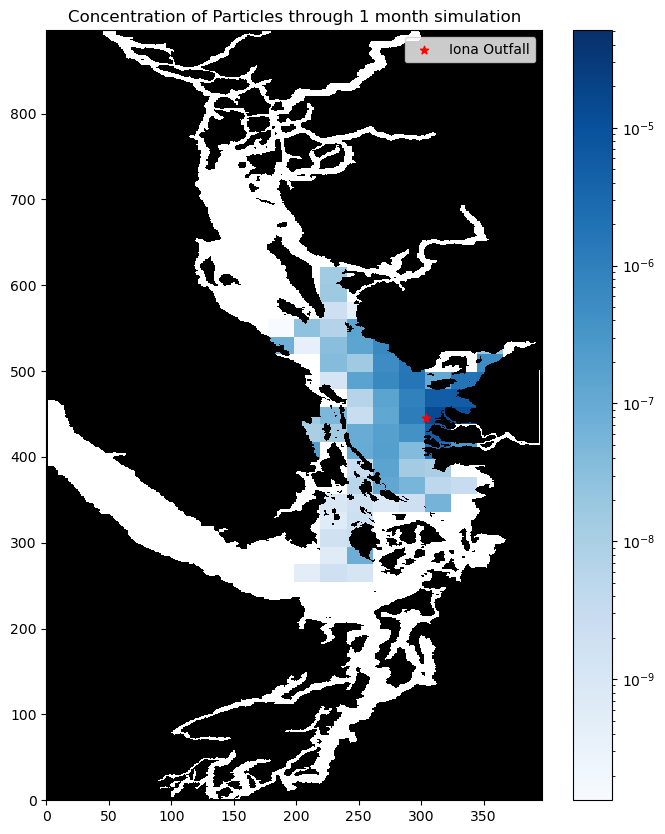

In [159]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
fig, ax = plt.subplots(figsize=(8,10))
c = ax.pcolormesh(x_lims, y_lims, concentration, cmap='Blues', norm=LogNorm(vmin=concentration.min().min(), vmax=concentration.max().max()))
ax.pcolormesh(tmask, cmap = cmap)
ax.set_xlim(0,tmask.x[-1])
ax.set_ylim(0, tmask.y[-1])
#
ax.scatter(y,x, c = 'r', marker = '*', label = 'Iona Outfall')
#
fig.colorbar(c, ax=ax)
ax.legend()
#
ax.set_title('Concentration of Particles through 1 month simulation')

In [45]:
Area_regions_depths = Area_regions_depths.rename(columns={"Unnamed: 0": "Depth"})
Area_regions_depths['Depth'] = mask['gdept_1d'][0].values
#
Volume_regions_depths = Volume_regions_depths.rename(columns={"Unnamed: 0": "Depth"})
Volume_regions_depths['Depth'] = mask['gdept_1d'][0].values

In [46]:
Volume_regions_depths['Depth']

0       0.500000
1       1.500003
2       2.500012
3       3.500031
4       4.500070
5       5.500151
6       6.500310
7       7.500623
8       8.501236
9       9.502433
10     10.504765
11     11.509311
12     12.518167
13     13.535412
14     14.568982
15     15.634287
16     16.761173
17     18.007135
18     19.481785
19     21.389979
20     24.100257
21     28.229915
22     34.685758
23     44.517725
24     58.484334
25     76.585584
26     98.062959
27    121.866518
28    147.089458
29    173.114482
30    199.573049
31    226.260306
32    253.066637
33    279.934550
34    306.834197
35    333.750170
36    360.674532
37    387.603203
38    414.534088
39    441.466110
Name: Depth, dtype: float64

-------------------------

**Time series of amount of particles per Region at all depths (Vertical Profiles Added)**

/tmp/ipykernel_2624478/3086298111.py:46: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_map.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')


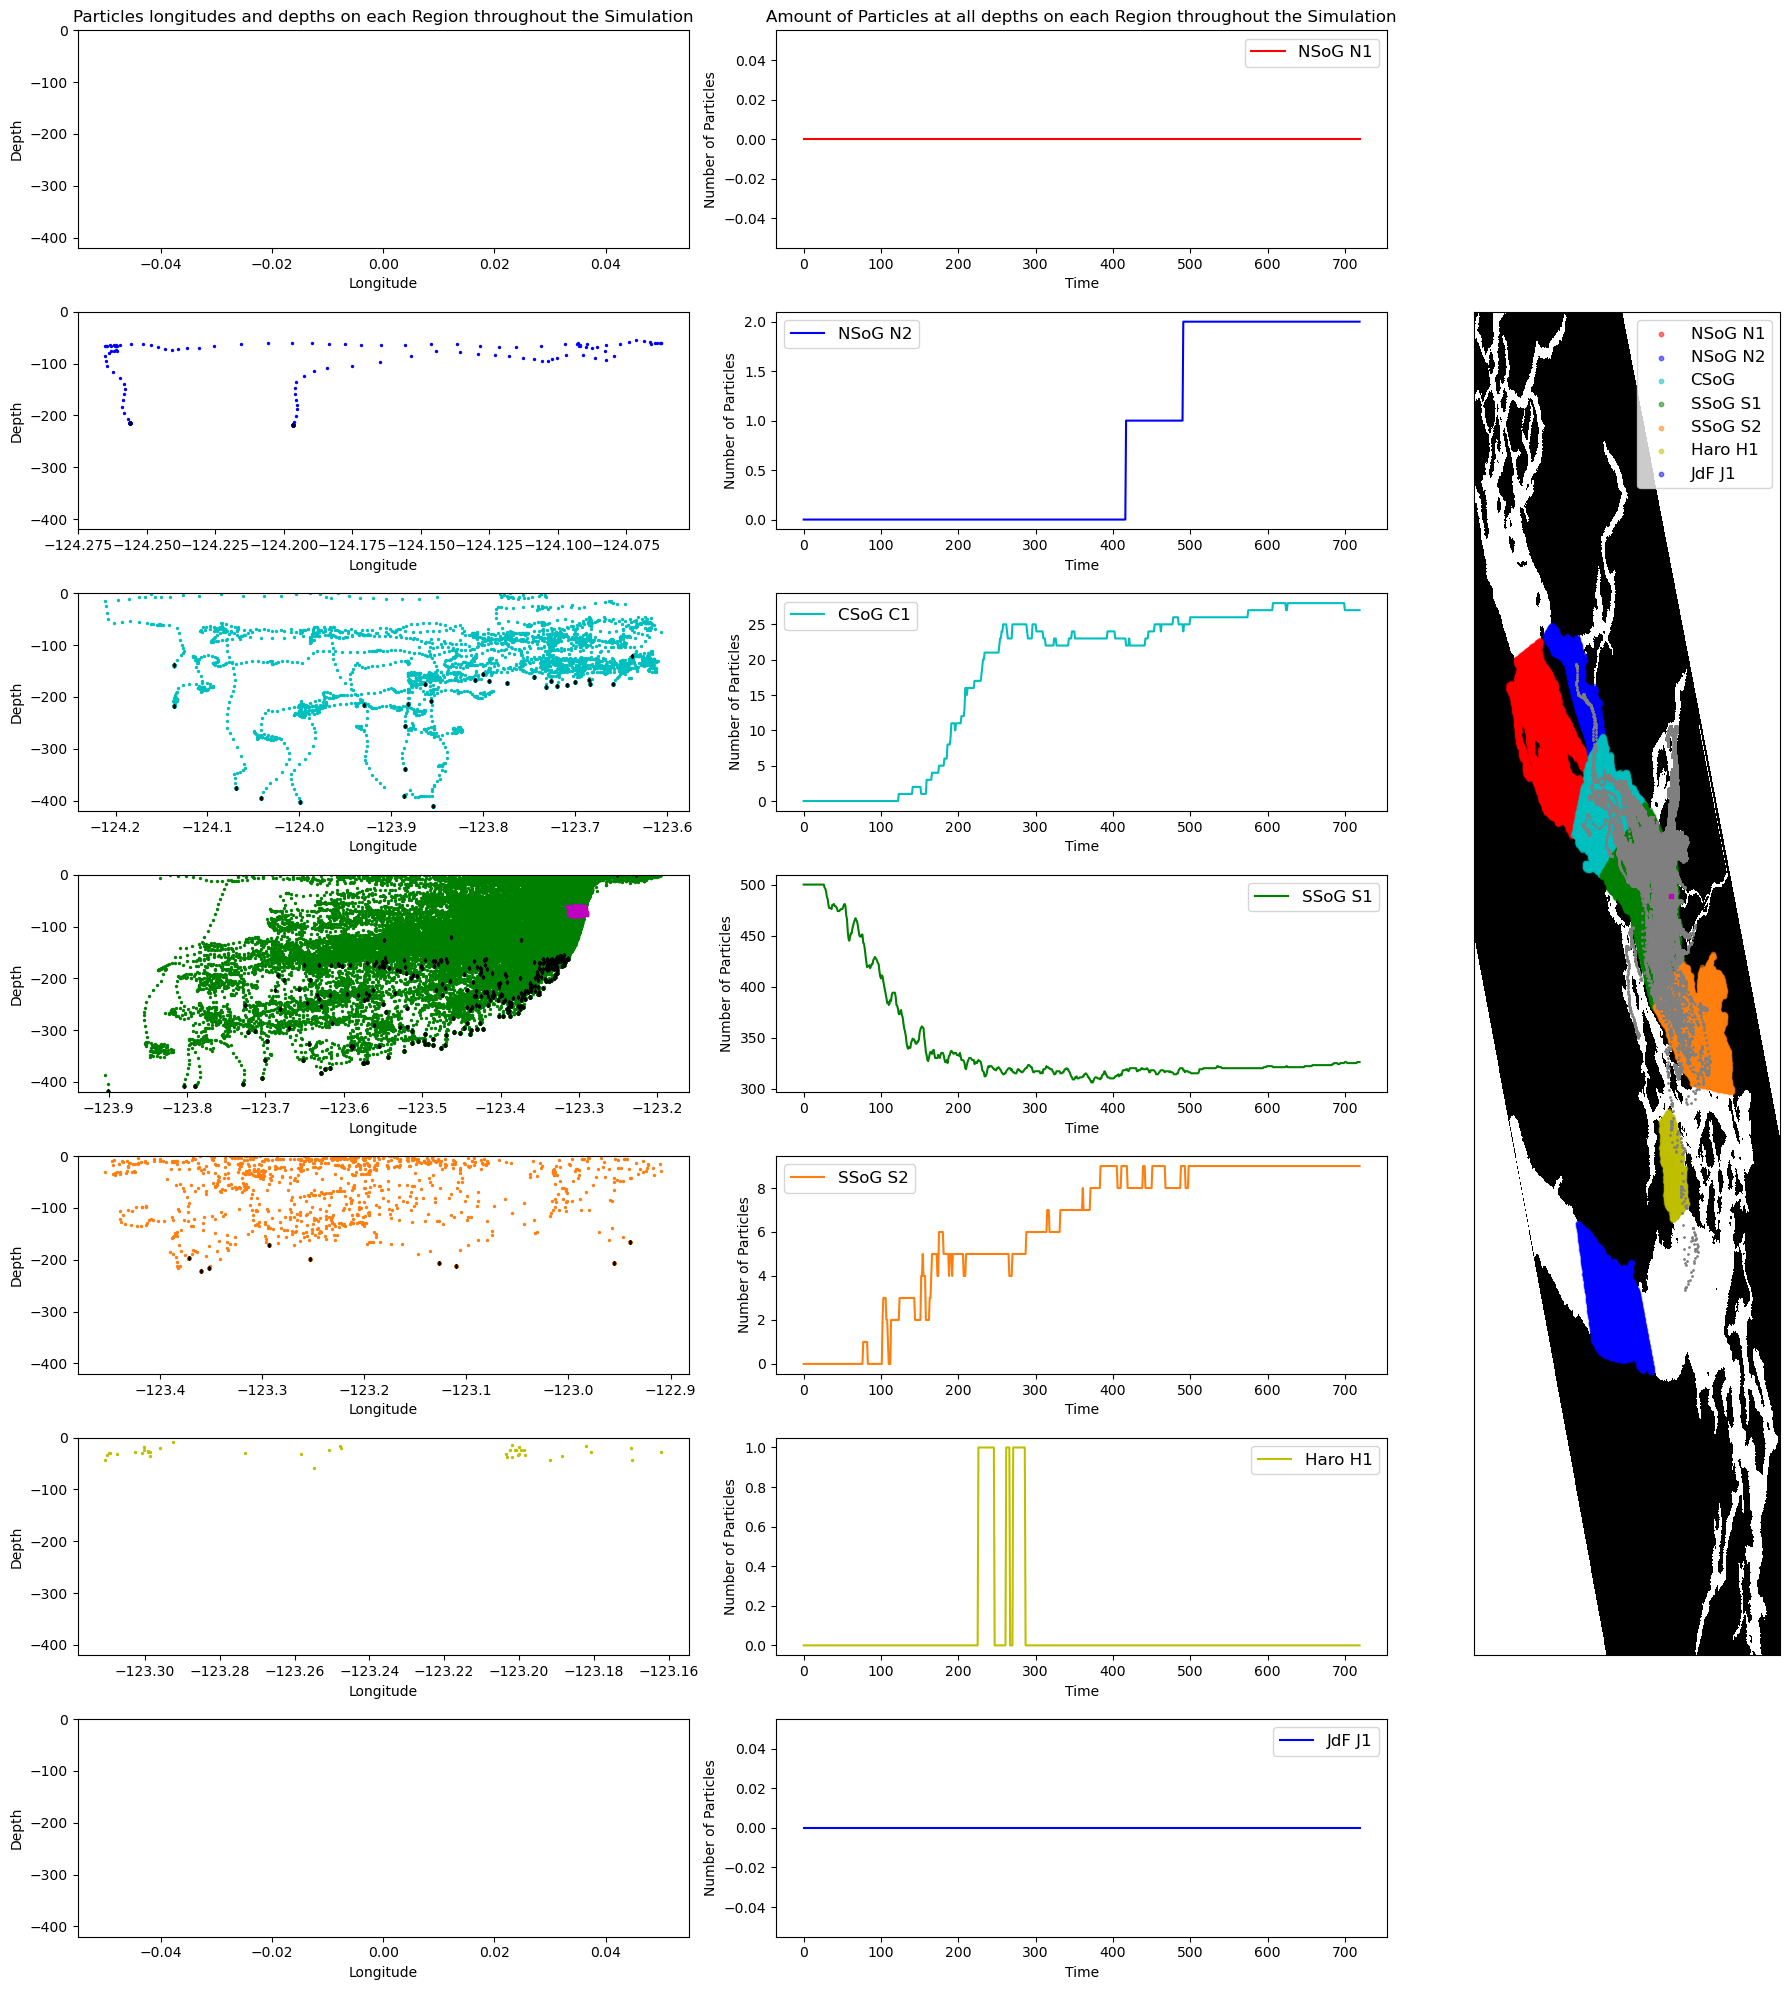

In [47]:
fig = plt.figure(figsize=(18, 20))  
gs = fig.add_gridspec(7, 3, width_ratios=[0.8,0.8, 0.4]) 
#
axs = [fig.add_subplot(gs[i, 0]) for i in range(7)]
ax_plots = [fig.add_subplot(gs[i, 1]) for i in range(7)]
ax_map = fig.add_subplot(gs[1:6, 2])
#
ax_plots[0].plot(n_particles_SSoG_N1, 'r', label='NSoG N1')
ax_plots[1].plot(n_particles_SSoG_N2, 'b', label='NSoG N2')
ax_plots[2].plot(n_particles_SSoG_C1, 'c', label='CSoG C1')
ax_plots[3].plot(n_particles_SSoG_S1, 'g', label='SSoG S1')
ax_plots[4].plot(n_particles_SSoG_S2, 'tab:orange', label='SSoG S2')
ax_plots[5].plot(n_particles_SSoG_H1, 'y', label='Haro H1')
ax_plots[6].plot(n_particles_SSoG_J1, 'b', label='JdF J1')
#
for i, ax in enumerate(ax_plots):
    ax.legend(fontsize=12)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Particles")
#
for i in range(n_steps):
    axs[0].scatter(polygons_dict['N1'][1]['lon'][i], polygons_dict['N1'][1]['depth'][i]*-1, c='r', s=2)
    axs[1].scatter(polygons_dict['N2'][1]['lon'][i], polygons_dict['N2'][1]['depth'][i]*-1, c='b', s=2)
    axs[2].scatter(polygons_dict['C1'][1]['lon'][i], polygons_dict['C1'][1]['depth'][i]*-1, c='c', s=2)
    axs[3].scatter(polygons_dict['S1'][1]['lon'][i], polygons_dict['S1'][1]['depth'][i]*-1, c='g', s=2)
    axs[4].scatter(polygons_dict['S2'][1]['lon'][i], polygons_dict['S2'][1]['depth'][i]*-1, c='tab:orange', s=2)
    axs[5].scatter(polygons_dict['H1'][1]['lon'][i], polygons_dict['H1'][1]['depth'][i]*-1, c='y', s=2)
    axs[6].scatter(polygons_dict['J1'][1]['lon'][i], polygons_dict['J1'][1]['depth'][i]*-1, c='b', s=2)
#
axs[0].scatter(polygons_dict['N1'][1]['lon'][n_steps-1], polygons_dict['N1'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
axs[1].scatter(polygons_dict['N2'][1]['lon'][n_steps-1], polygons_dict['N2'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
axs[2].scatter(polygons_dict['C1'][1]['lon'][n_steps-1], polygons_dict['C1'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
axs[3].scatter(polygons_dict['S1'][1]['lon'][n_steps-1], polygons_dict['S1'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
axs[4].scatter(polygons_dict['S2'][1]['lon'][n_steps-1], polygons_dict['S2'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
axs[5].scatter(polygons_dict['H1'][1]['lon'][n_steps-1], polygons_dict['H1'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
axs[6].scatter(polygons_dict['J1'][1]['lon'][n_steps-1], polygons_dict['J1'][1]['depth'][n_steps-1]*-1, c='k', s=4, marker='d')
#

axs[3].scatter(polygons_dict['S1'][1]['lon'][0], polygons_dict['S1'][1]['depth'][0]*-1, c='m', s=4, marker='s')
    
for i, ax in enumerate(axs):
    ax.set_ylim(-420,0)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Depth')
#
ax_map.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')
ax_map.scatter(lon_NSoG_N1, lat_NSoG_N1, s=10, color='r', alpha=0.5, label='NSoG N1')
ax_map.scatter(lon_NSoG_N2, lat_NSoG_N2, s=10, color='b', alpha=0.5, label='NSoG N2')
ax_map.scatter(lon_CSoG_C1, lat_CSoG_C1, s=10, color='c', alpha=0.5, label='CSoG')
ax_map.scatter(lon_SSoG_S1, lat_SSoG_S1, s=10, color='g', alpha=0.5, label='SSoG S1')
ax_map.scatter(lon_SSoG_S2, lat_SSoG_S2, s=10, color='tab:orange', alpha=0.5, label='SSoG S2')
ax_map.scatter(lon_Haro_H1, lat_Haro_H1, s=10, color='y', alpha=0.5, label='Haro H1')
ax_map.scatter(lon_Juan_J1, lat_Juan_J1, s=10, color='b', alpha=0.5, label='JdF J1')
ax_map.scatter(data.lon, data.lat, s=1, color='tab:gray')
ax_map.scatter(clon[0], clat[0], s=10, color='m', marker='s')
#
ax_map.set_xlim(-125.3,-122.2)
ax_map.set_ylim(47.5,50.5)
#
ax_map.legend(fontsize=12)
ax_map.tick_params(
    which='both', bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False
)
#
ax_plots[0].set_title('Amount of Particles at all depths on each Region throughout the Simulation', fontsize = 12)
axs[0].set_title('Particles longitudes and depths on each Region throughout the Simulation', fontsize = 12)

fig.tight_layout()
plt.show()

In [48]:
np.mean(polygons_dict['S1'][1]['depth'][0])
np.std(polygons_dict['S1'][1]['depth'][0])

5.92661403213443

/tmp/ipykernel_2624478/1293003963.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_map.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')


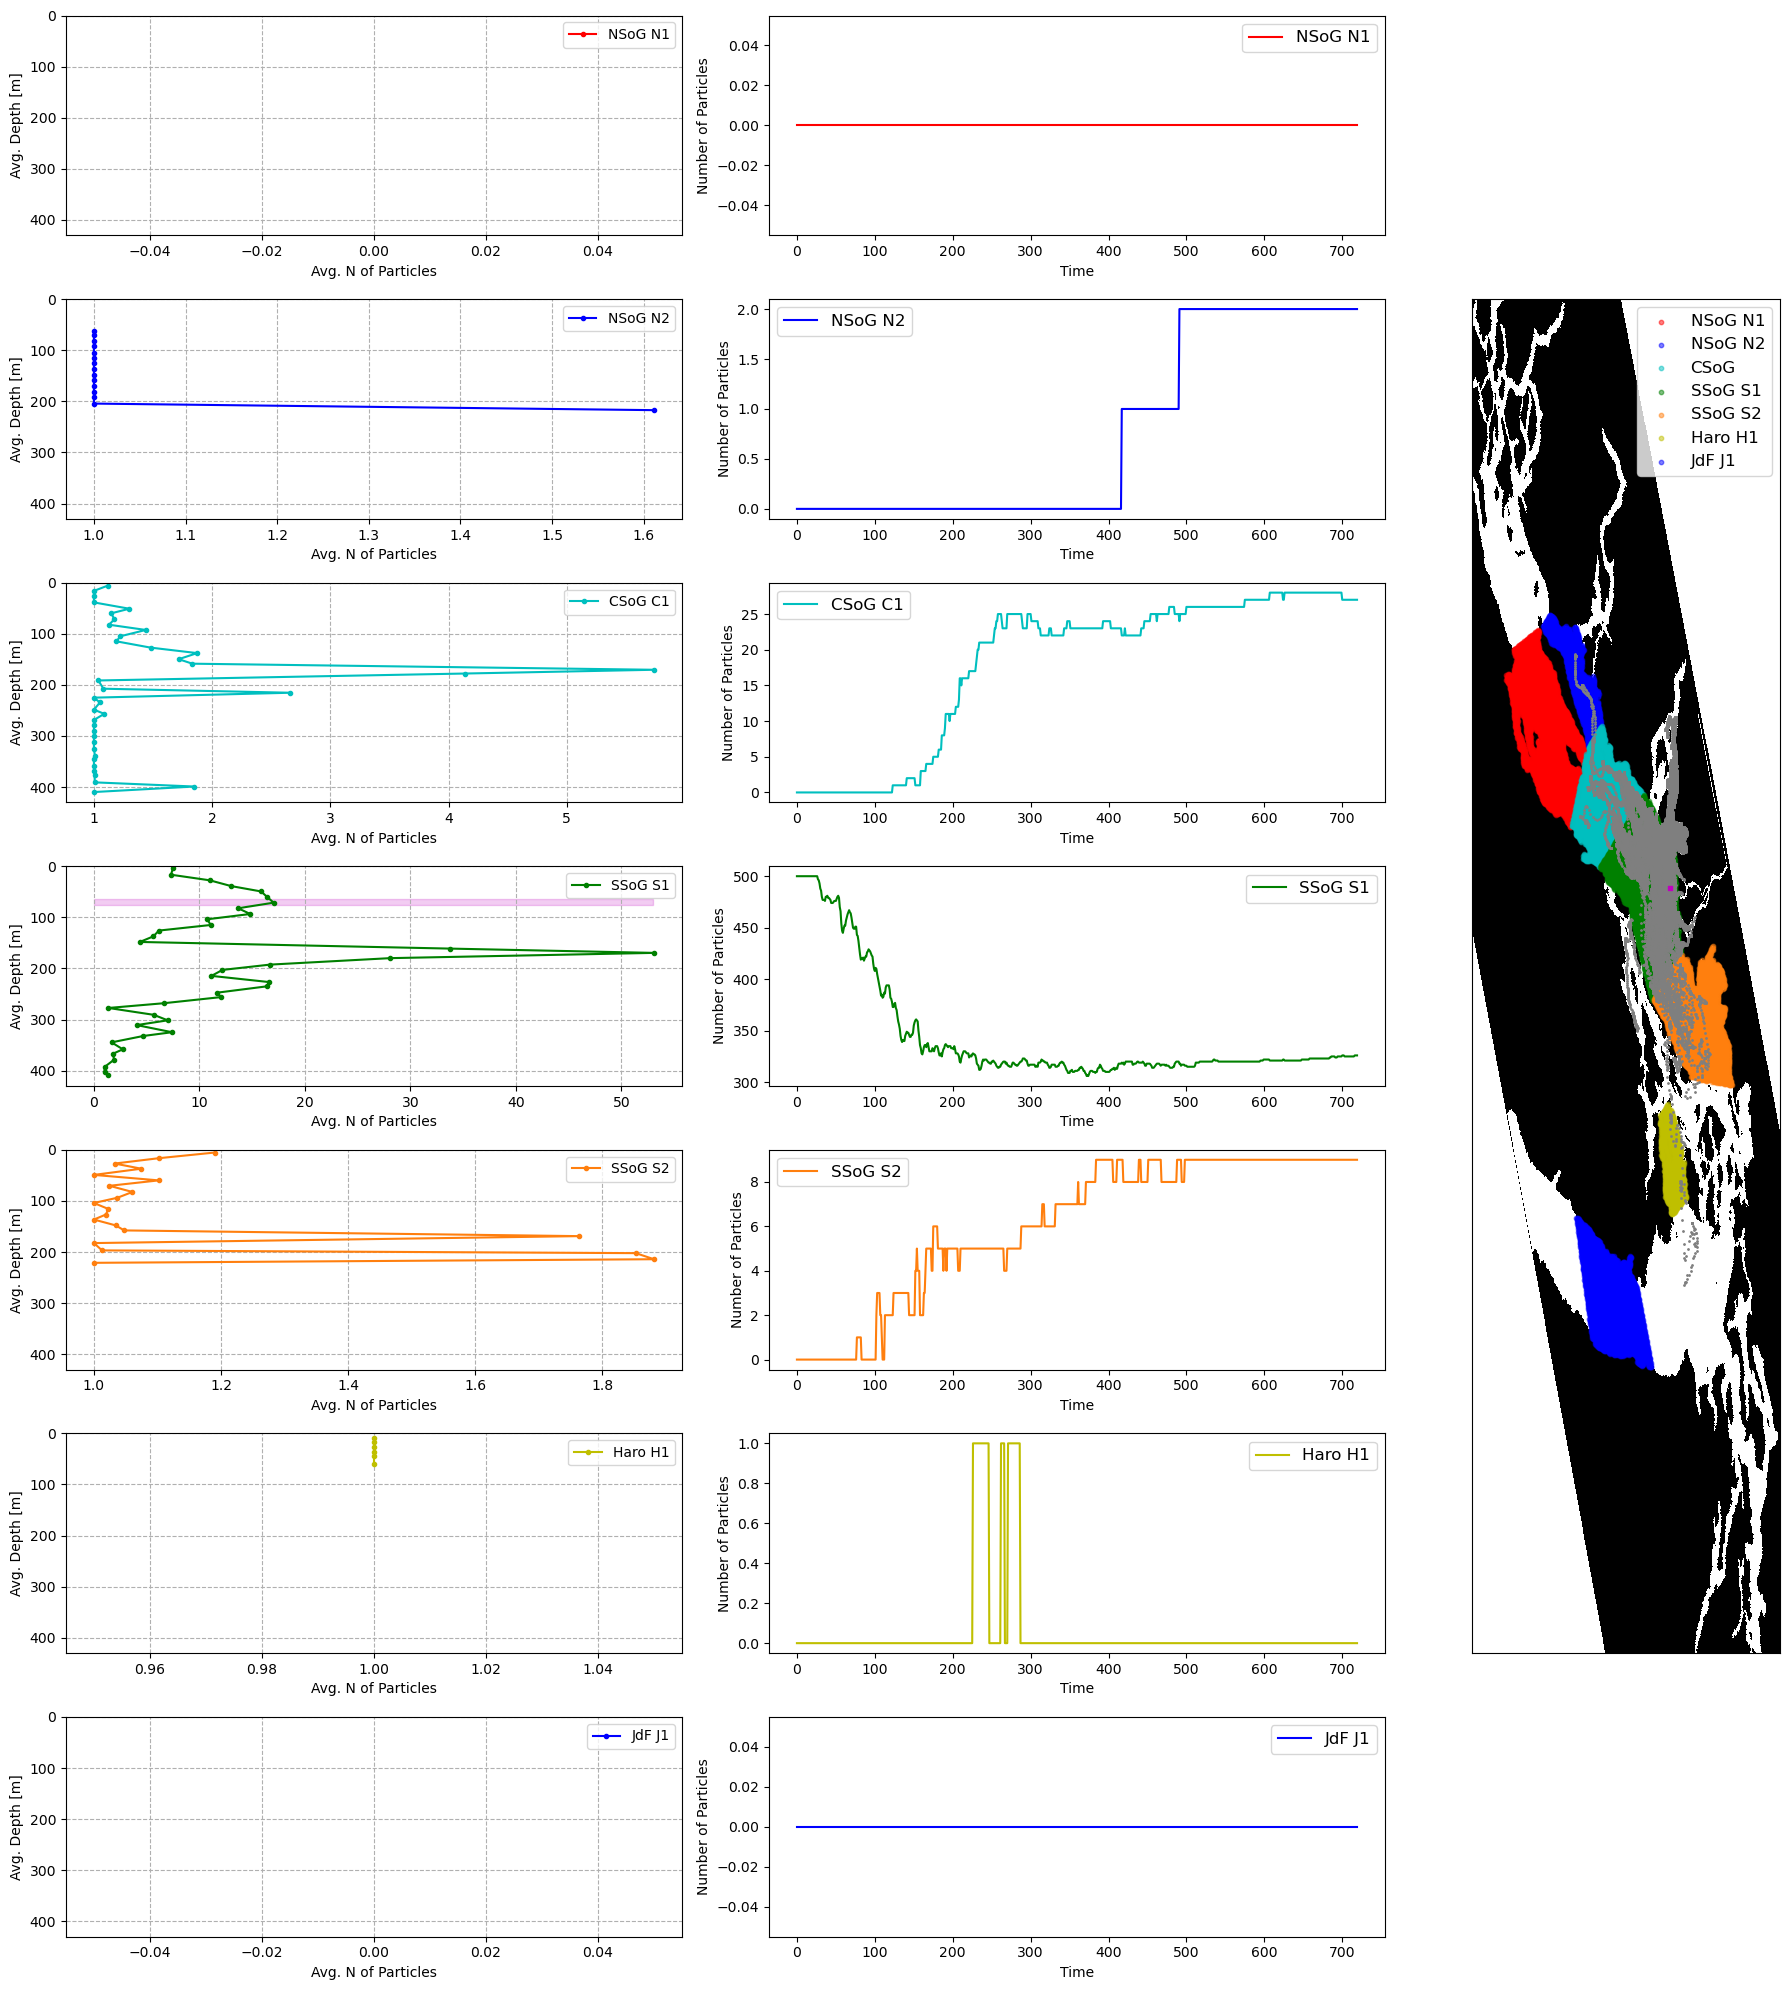

In [49]:
fig = plt.figure(figsize=(18, 20))  
gs = fig.add_gridspec(7, 3, width_ratios=[0.8,0.8, 0.4]) 
#
axs = [fig.add_subplot(gs[i, 0]) for i in range(7)]
ax_plots = [fig.add_subplot(gs[i, 1]) for i in range(7)]
ax_map = fig.add_subplot(gs[1:6, 2])
#
ax_plots[0].plot(n_particles_SSoG_N1, 'r', label='NSoG N1')
ax_plots[1].plot(n_particles_SSoG_N2, 'b', label='NSoG N2')
ax_plots[2].plot(n_particles_SSoG_C1, 'c', label='CSoG C1')
ax_plots[3].plot(n_particles_SSoG_S1, 'g', label='SSoG S1')
ax_plots[4].plot(n_particles_SSoG_S2, 'tab:orange', label='SSoG S2')
ax_plots[5].plot(n_particles_SSoG_H1, 'y', label='Haro H1')
ax_plots[6].plot(n_particles_SSoG_J1, 'b', label='JdF J1')
#
for i, ax in enumerate(ax_plots):
    ax.legend(fontsize=12)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Particles")
#
axs[0].plot(vertical_N1['Avg. Particles'], vertical_N1['Avg. Depth'], '.-r', label='NSoG N1')
axs[1].plot(vertical_N2['Avg. Particles'], vertical_N2['Avg. Depth'], '.-b', label='NSoG N2')
axs[2].plot(vertical_C1['Avg. Particles'], vertical_C1['Avg. Depth'], '.-c', label='CSoG C1')
axs[3].plot(vertical_S1['Avg. Particles'], vertical_S1['Avg. Depth'], '.-g', label='SSoG S1')
axs[4].plot(vertical_S2['Avg. Particles'], vertical_S2['Avg. Depth'], 'tab:orange',linestyle='-', marker='.', label='SSoG S2')
axs[5].plot(vertical_H1['Avg. Particles'], vertical_H1['Avg. Depth'], '.-y', label='Haro H1')
axs[6].plot(vertical_J1['Avg. Particles'], vertical_J1['Avg. Depth'], '.-b', label='JdF J1')
#
# Plot release depths
mm = np.mean(polygons_dict['S1'][1]['depth'][0])
mstd = np.std(polygons_dict['S1'][1]['depth'][0])
axs[3].fill_between(np.arange(0,np.max(vertical_S1['Avg. Particles'])), mm - mstd, mm + mstd, color='m', alpha=0.2)
#
for ax in axs:
    ax.set_ylim(0, 430)
    ax.invert_yaxis()
    ax.legend(fontsize=10)
    ax.set_xlabel("Avg. N of Particles")
    ax.set_ylabel("Avg. Depth [m]")
    ax.grid(linestyle = '--')
#
ax_map.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')
ax_map.scatter(lon_NSoG_N1, lat_NSoG_N1, s=10, color='r', alpha=0.5, label='NSoG N1')
ax_map.scatter(lon_NSoG_N2, lat_NSoG_N2, s=10, color='b', alpha=0.5, label='NSoG N2')
ax_map.scatter(lon_CSoG_C1, lat_CSoG_C1, s=10, color='c', alpha=0.5, label='CSoG')
ax_map.scatter(lon_SSoG_S1, lat_SSoG_S1, s=10, color='g', alpha=0.5, label='SSoG S1')
ax_map.scatter(lon_SSoG_S2, lat_SSoG_S2, s=10, color='tab:orange', alpha=0.5, label='SSoG S2')
ax_map.scatter(lon_Haro_H1, lat_Haro_H1, s=10, color='y', alpha=0.5, label='Haro H1')
ax_map.scatter(lon_Juan_J1, lat_Juan_J1, s=10, color='b', alpha=0.5, label='JdF J1')
ax_map.scatter(data.lon, data.lat, s=1, color='tab:gray')
ax_map.scatter(clon[0], clat[0], s=10, color='m', marker='s')
#
ax_map.set_xlim(-125.3,-122.2)
ax_map.set_ylim(47.5,50.5)
#
ax_map.legend(fontsize=12)
ax_map.tick_params(
    which='both', bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False
)
#
#ax_plots[0].set_title('Amount of Particles at all depths on each Region throughout the Simulation', fontsize = 12)
#axs[0].set_title('Particles longitudes and depths on each Region throughout the Simulation', fontsize = 12)
fig.tight_layout()
plt.show()

/tmp/ipykernel_2624478/4280285963.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_map.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')


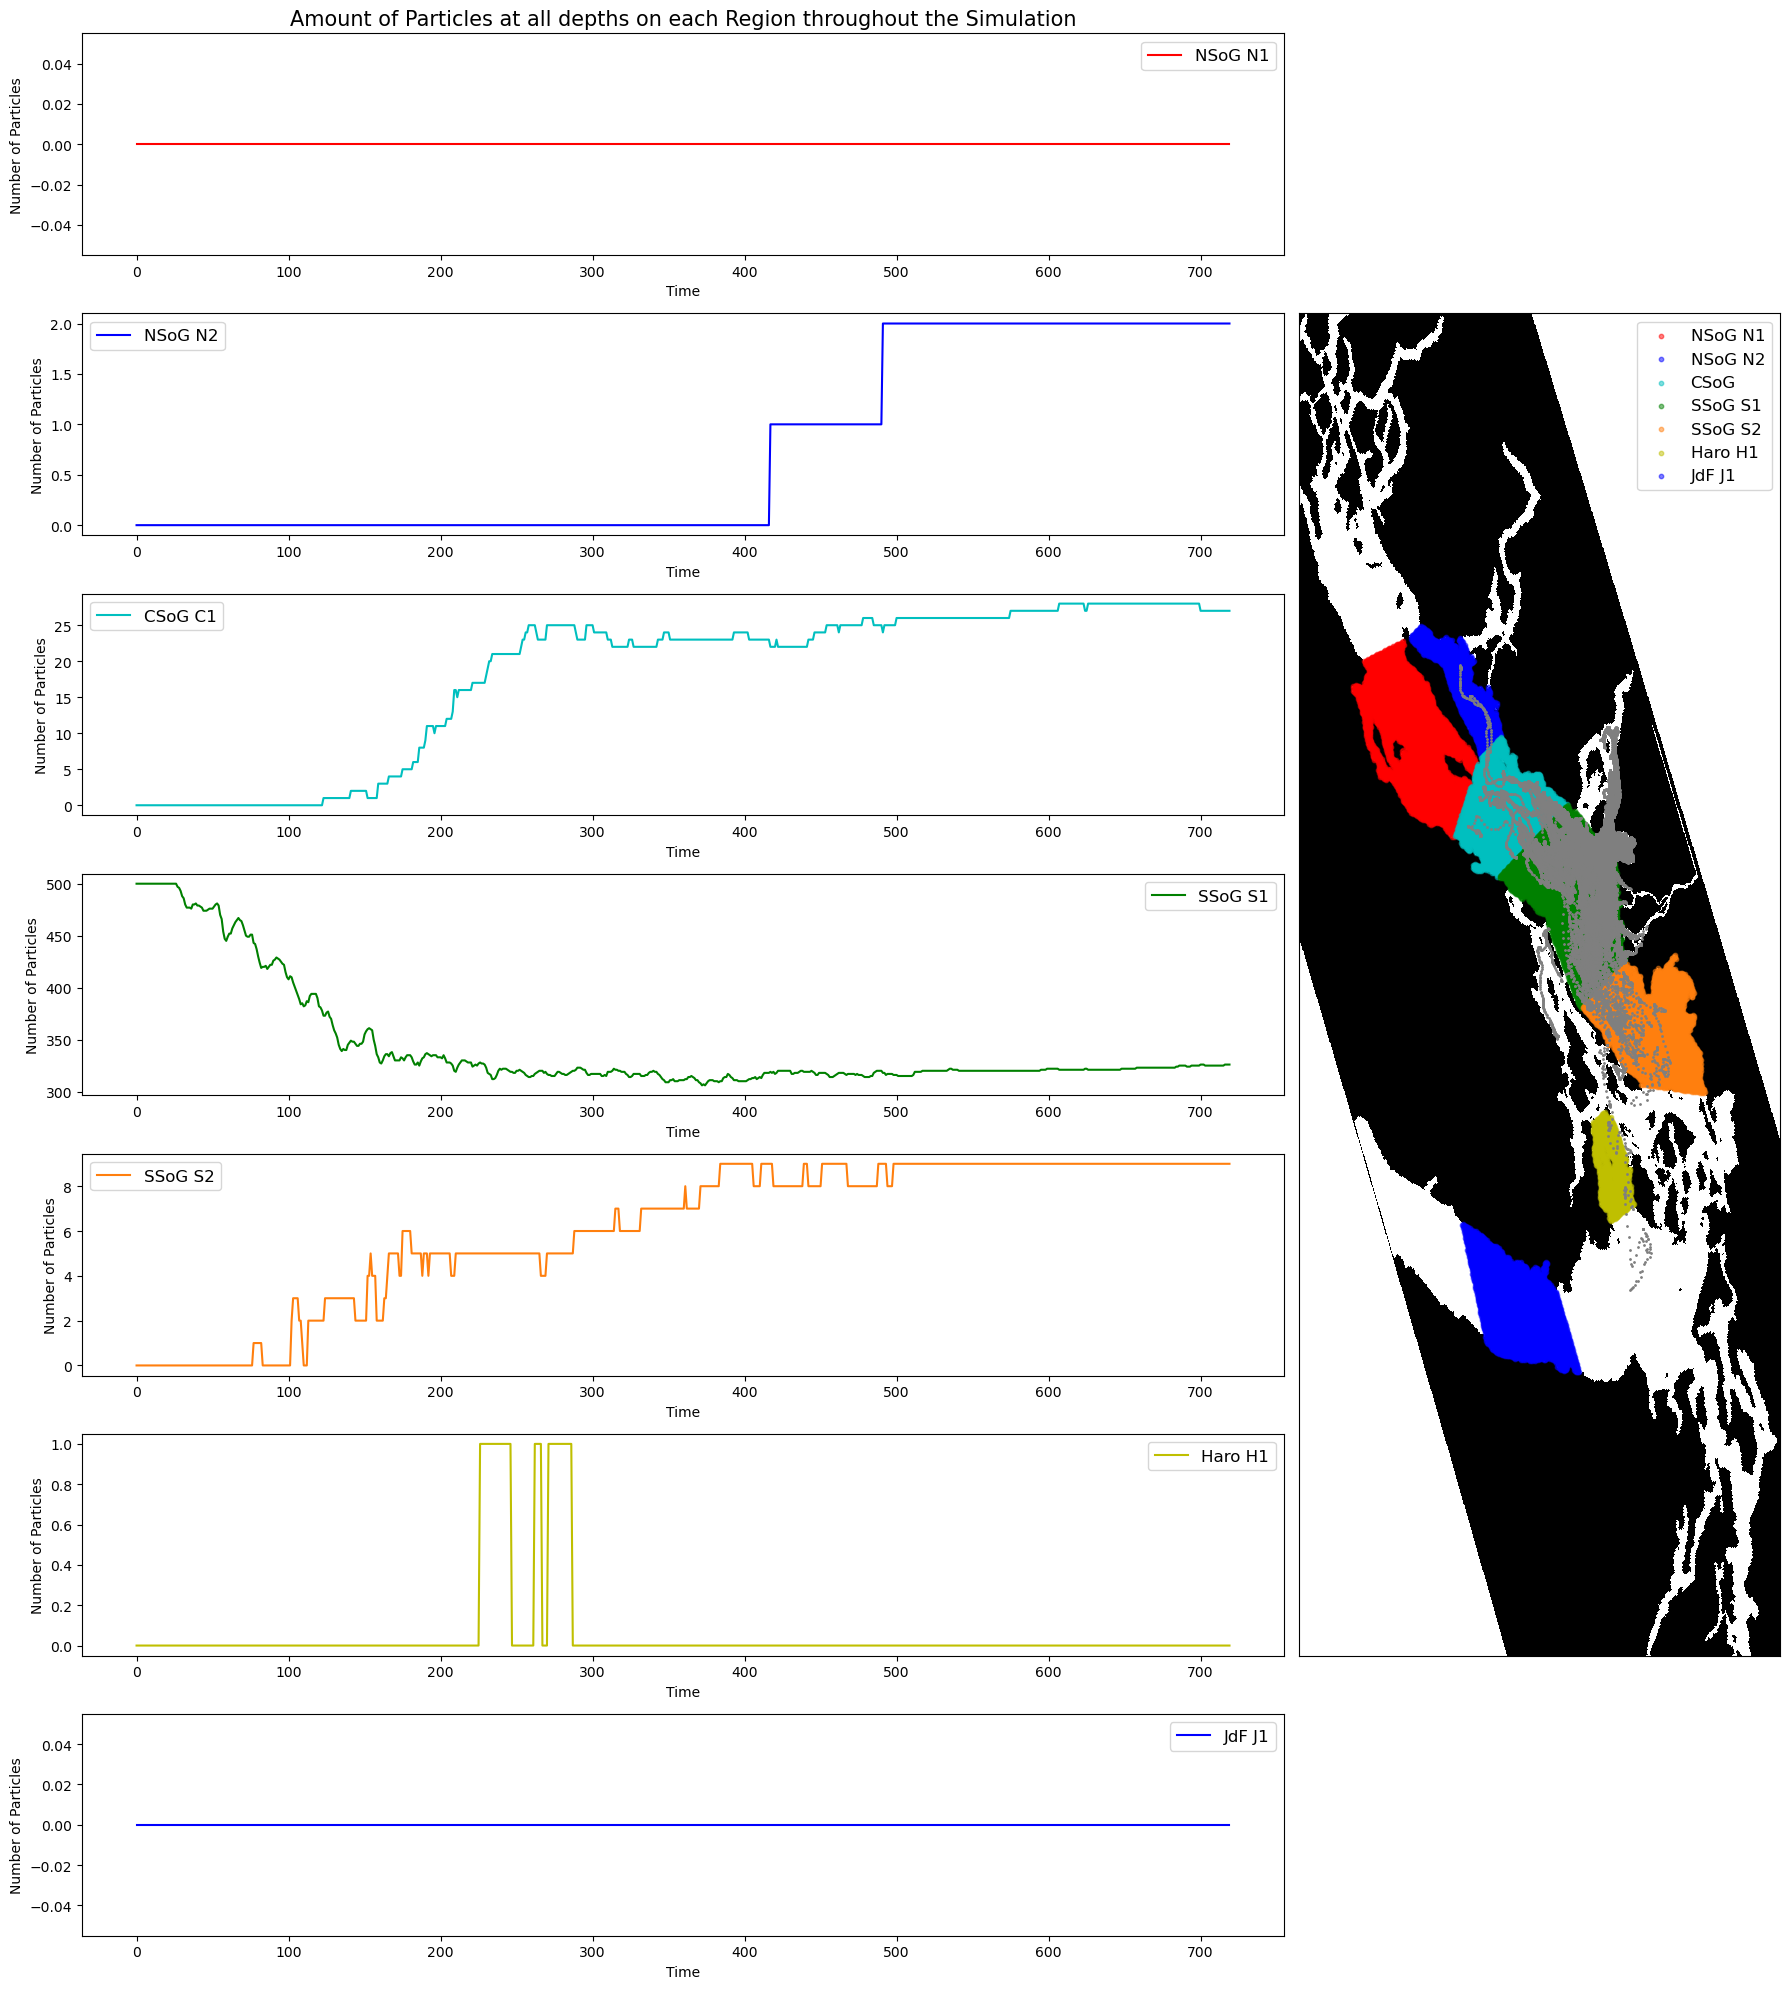

In [50]:
fig = plt.figure(figsize=(18, 20))  
gs = fig.add_gridspec(7, 2, width_ratios=[1, 0.4]) 
#
ax_plots = [fig.add_subplot(gs[i, 0]) for i in range(7)]
ax_map = fig.add_subplot(gs[1:6, 1])
#
ax_plots[0].plot(n_particles_SSoG_N1, 'r', label='NSoG N1')
ax_plots[1].plot(n_particles_SSoG_N2, 'b', label='NSoG N2')
ax_plots[2].plot(n_particles_SSoG_C1, 'c', label='CSoG C1')
ax_plots[3].plot(n_particles_SSoG_S1, 'g', label='SSoG S1')
ax_plots[4].plot(n_particles_SSoG_S2, 'tab:orange', label='SSoG S2')
ax_plots[5].plot(n_particles_SSoG_H1, 'y', label='Haro H1')
ax_plots[6].plot(n_particles_SSoG_J1, 'b', label='JdF J1')
#
for i, ax in enumerate(ax_plots):
    ax.legend(fontsize=12)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Particles")
#
ax_map.pcolormesh(nav_lon, nav_lat,tmask, cmap = 'grey')
ax_map.scatter(lon_NSoG_N1, lat_NSoG_N1, s=10, color='r', alpha=0.5, label='NSoG N1')
ax_map.scatter(lon_NSoG_N2, lat_NSoG_N2, s=10, color='b', alpha=0.5, label='NSoG N2')
ax_map.scatter(lon_CSoG_C1, lat_CSoG_C1, s=10, color='c', alpha=0.5, label='CSoG')
ax_map.scatter(lon_SSoG_S1, lat_SSoG_S1, s=10, color='g', alpha=0.5, label='SSoG S1')
ax_map.scatter(lon_SSoG_S2, lat_SSoG_S2, s=10, color='tab:orange', alpha=0.5, label='SSoG S2')
ax_map.scatter(lon_Haro_H1, lat_Haro_H1, s=10, color='y', alpha=0.5, label='Haro H1')
ax_map.scatter(lon_Juan_J1, lat_Juan_J1, s=10, color='b', alpha=0.5, label='JdF J1')
ax_map.scatter(data.lon, data.lat, s=1, color='tab:gray')
#
ax_map.set_xlim(-125.3,-122.2)
ax_map.set_ylim(47.5,50.5)
#
ax_map.legend(fontsize=12)
ax_map.tick_params(
    which='both', bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False
)
#
ax_plots[0].set_title('Amount of Particles at all depths on each Region throughout the Simulation', fontsize = 15)
fig.tight_layout()
plt.show()

Sampling depths from Sun's paper (2023):
- 2 m
- 25 m 
- 50 m 
- 75 m 
- 150 m 
- 160 m 
- 195 m 
- 330 m 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Get Tidal Signals for each region**

In [37]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

In [38]:
begin = datetime(2022, 1, 1) 
end = (datetime(2022, 1, 1) + timedelta(30))
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)

In [39]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [40]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [41]:
def get_time_series(files_input_U, files_input_V, y_coordinate, x_coordinate, depth = 0, dimension = 'time_counter', variable_U = 'vozocrtx', variable_V = 'vomecrty'):
    #    
    # Set up for depth = 0 (surface)
    data_list_U = []
    data_list_V = []
    time = []
    for i in range(len(files_input_U)):
        datau = xr.open_dataset(files_input_U[i][0])[variable_U][:,depth, y_coordinate, x_coordinate]
        data_list_U.append(datau)
        #
        datav = xr.open_dataset(files_input_V[i][0])[variable_V][:,depth, y_coordinate, x_coordinate]
        data_list_V.append(datav)
        #
        t = xr.open_dataset(files_input_U[i][0])[dimension]
        time.append(t)
    #
    data_series_U = xr.concat(data_list_U, dim = dimension)  
    data_series_V = xr.concat(data_list_V, dim = dimension)
    T = xr.concat(time, dim = dimension) 
    #
    U = pd.DataFrame(data_series_U.values, columns = ['Velocity U'], index=T)
    V = pd.DataFrame(data_series_V.values, columns = ['Velocity V'], index = T)
    return U, V  

In [42]:
# function to get grid point gridX and gridY
#path_NEMO = make_prefix(start,path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [43]:
clat = [49.195045]
clon = [-123.301956]

In [44]:
y, x = finder(clat[0], clon[0])

In [40]:
series_U, series_V = get_time_series(files_U, files_V, y, x)

In [41]:
UV = pd.DataFrame(np.sqrt(series_U['Velocity U'] ** 2 + series_V['Velocity V'] ** 2), columns = ['Velocity UV'])     

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(series_U, 'b')
ax.plot(series_V, 'r')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Map of Model Domain**

In [10]:
name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/PBDEs_run_for_30_days_500_particles_20220101_1n_20220131_1n.zarr'

In [11]:
from mpl_toolkits.basemap import Basemap
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 
import xarray as xr
import numpy as np
#
#
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])
clat = 49.195045
clon = -123.301956

In [ ]:
fig, ax = plt.subplots(figsize = (10,12))
rotation_angle = 10  # Rotation angle in degrees
#
#
w_map = [-126.5, -121, 46.7, 51.3]
# Define a rotated pole projection with a shifted pole to create the rotation effect
m = Basemap(projection='lcc', resolution='h',
            lon_0=clon, lat_0=clat,
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
#
lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
#
labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
#
m.drawcoastlines(zorder=1)
m.fillcontinents(color='Burlywood', zorder=0)
m.drawmeridians(lons, color='k',labels = labels[0], yoffset=None, zorder=2)
m.drawparallels(lats, color='k',labels = labels[1], xoffset=None, zorder=2)
m.drawrivers(zorder=2)
#
x, y = m(coords.nav_lon, coords.nav_lat)
#
blevels = list(np.arange(0,500,20))
#
C = ax.contourf(x, y, mask.totaldepth[:,:], zorder=1,cmap = cmap, levels=blevels, extend='both')
ax.contourf(x, y, mask.totaldepth[:,:], [-0.01, 0.01], colors='lightgray', zorder=3)
ax.contour( x, y, mask.totaldepth[:,:], [0], colors='Black', zorder=4)
#
C_lon, C_lat = m(clon, clat)
ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
#
cbar = fig.colorbar(C, ax=ax, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
#
ax.text(0.02, 0.01, 'SalishSeaCast Model Domain', transform=ax.transAxes, fontweight = 'bold')
#
ax.text(0.05, 0.25, 'Juan De Fuca Strait\nOpen Boundary', transform=ax.transAxes, fontsize = 13, zorder=3)
ax.arrow(0.20, 0.30,  0.1,  0.070, head_width=0.01, fc='w', ec='b', transform=ax.transAxes, zorder=3)
#
ax.text(0.01, 0.42, 'Johnstone Strait\nOpen Boundary', transform=ax.transAxes, fontsize = 13, zorder=3)
ax.arrow(0.12, 0.47,  0.00,  0.330, head_width=0.01, fc='w', ec='b', transform=ax.transAxes, zorder=3)
#
# IONA
#
ax.plot(C_lon, C_lat, 'ko', markersize=8, markerfacecolor='r', zorder=3)
ax.text(0.560, 0.840, 'Iona Outfall', transform=ax.transAxes, fontsize = 13, zorder=3, fontweight = 'bold')
ax.arrow(0.65, 0.82,  -0.042, -0.260, head_width=0.01, fc='r', ec='k', transform=ax.transAxes, zorder=3)
#
# VANCOUVER
#
V_lon, V_lat = m(-123.10, 49.25)
ax.plot(V_lon, V_lat, 'ko', markersize=8, markerfacecolor='b', zorder=3)
ax.text(0.67, 0.67, 'Vancouver', transform=ax.transAxes, fontsize = 13, zorder=3)
ax.arrow(0.74, 0.66,  -0.082, -0.095, head_width=0.01, fc='b', ec='k', transform=ax.transAxes, zorder=3)
# FRASER RIVER
#
ax.text(0.8, 0.5, 'Fraser River', transform=ax.transAxes, fontsize = 13, zorder=3)
ax.arrow(0.8, 0.52, -0.08, 0.030, head_width=0.01, fc='c', ec='k', transform=ax.transAxes, zorder=3)
#
# SoG
#
ax.text(0.46, 0.46, 'Strait of Georgia', rotation=-40, transform=ax.transAxes, fontsize = 13, zorder=3)
#
# PS
#
ax.text(0.53, 0.110, 'Puget\nSound', transform=ax.transAxes, fontsize = 13, zorder=3)